<a href="https://colab.research.google.com/github/noahnguyen2004/Loan-Default-Prediction/blob/main/loan_lending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from scikitplot.metrics import plot_roc_curve

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.losses import BinaryCrossentropy

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/loan default/loan_lending_club.csv', encoding = 'latin-1',
                 usecols=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
                            'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti',
                            'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                            'mort_acc', 'pub_rec_bankruptcies'])
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,credit_card,Computer,27.65,Jan-1985,3.00,0.00,13648.00,83.7%,9.00,f,Individual,NaN,0.00
1,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,car,bike,1.00,Apr-1999,3.00,0.00,1687.00,9.4%,4.00,f,Individual,NaN,0.00
2,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,small_business,real estate business,8.72,Nov-2001,2.00,0.00,2956.00,98.5%,10.00,f,Individual,NaN,0.00
3,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,other,personel,20.00,Feb-1996,10.00,0.00,5598.00,21%,37.00,f,Individual,NaN,0.00
4,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Fully Paid,other,Personal,17.94,Jan-1996,15.00,0.00,27783.00,53.9%,38.00,f,Individual,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925489,10000.00,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,Apr-2017,Fully Paid,debt_consolidation,Debt consolidation,19.55,Sep-1993,15.00,0.00,9751.00,15.7%,27.00,w,Individual,0.00,0.00
2925490,10050.00,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,20.56,May-1993,15.00,0.00,14300.00,47%,21.00,w,Individual,0.00,0.00
2925491,6000.00,36 months,11.44%,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,Apr-2017,Fully Paid,credit_card,Credit card refinancing,19.99,May-1990,9.00,0.00,1356.00,10.1%,18.00,w,Individual,0.00,0.00
2925492,30000.00,60 months,25.49%,889.18,E,E4,Assistant Manager,4 years,MORTGAGE,105700.00,Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,27.26,Nov-1997,12.00,0.00,15252.00,72.6%,23.00,w,Individual,3.00,0.00


# Exploratory Data Analysis (EDA)

In [4]:
loan_status_counts = df['loan_status'].value_counts()

loan_status_df = pd.DataFrame({
    'Loan Status': loan_status_counts.index,
    'Counts': loan_status_counts.values
})

loan_status_df

,Loan Status,Counts
0,Fully Paid,1497783
1,Current,1031016
2,Charged Off,362548
3,Late (31-120 days),16154
4,In Grace Period,10028
5,Late (16-30 days),2719
6,Issued,2062
7,Does not meet the credit policy. Status:Fully ...,1988
8,Does not meet the credit policy. Status:Charge...,761
9,Default,433


The goal of this project is to predict whether a borrower can pay off the installments or not, so only Fully Paid and Charged Off are taken into account.
- Charged Off: the borrower has become delinquent for a period of time and the company did not believe the borrower can pay back the loan amount, but the borrower still has the responsibility to do so.

In [5]:
# retain binary class (Fully Paid, Charged Off) for loan_status as target, and drop the rest
df.drop(df[df['loan_status'] == 'Late (31-120 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'In Grace Period'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Current'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Late (16-30 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Issued'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Default'].index, inplace = True)

df = df.reset_index(drop=True)
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,credit_card,Computer,27.65,Jan-1985,3.00,0.00,13648.00,83.7%,9.00,f,Individual,NaN,0.00
1,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,car,bike,1.00,Apr-1999,3.00,0.00,1687.00,9.4%,4.00,f,Individual,NaN,0.00
2,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,small_business,real estate business,8.72,Nov-2001,2.00,0.00,2956.00,98.5%,10.00,f,Individual,NaN,0.00
3,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,other,personel,20.00,Feb-1996,10.00,0.00,5598.00,21%,37.00,f,Individual,NaN,0.00
4,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Fully Paid,other,Personal,17.94,Jan-1996,15.00,0.00,27783.00,53.9%,38.00,f,Individual,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860328,10000.00,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,Apr-2017,Fully Paid,debt_consolidation,Debt consolidation,19.55,Sep-1993,15.00,0.00,9751.00,15.7%,27.00,w,Individual,0.00,0.00
1860329,10050.00,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,20.56,May-1993,15.00,0.00,14300.00,47%,21.00,w,Individual,0.00,0.00
1860330,6000.00,36 months,11.44%,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,Apr-2017,Fully Paid,credit_card,Credit card refinancing,19.99,May-1990,9.00,0.00,1356.00,10.1%,18.00,w,Individual,0.00,0.00
1860331,30000.00,60 months,25.49%,889.18,E,E4,Assistant Manager,4 years,MORTGAGE,105700.00,Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,27.26,Nov-1997,12.00,0.00,15252.00,72.6%,23.00,w,Individual,3.00,0.00


## Appropriate data type of each feature
- loan_amnt: numerical -> float
- term: categorical -> string
- int_rate: numerical -> float
- installment: numerical -> float
- grade: categorical -> string
- sub_grade: categorical -> string
- emp_title: categorical -> string
- emp_length: categorical -> string
- home_ownership: categorical -> string
- annual_inc: numerical -> float
- verification_status: categorical -> string
- issue_d: categorical -> string
- loan_status: categorical (target) -> string
- purpose: categorical -> string
- title: categorical -> string
- dti: numerical -> float
- earliest_cr_line: categorical -> string
- open_acc: numerical -> float
- pub_rec: categorical -> int
- revol_bal: numerical -> float
- revol_util: numerical -> float
- total_acc: numerical -> float
- initial_list_status: categorical -> string
- application_type: categorical -> string
- mort_acc: numerical -> int
- pub_rec_bankruptcies: numerical -> int

### We notice some issues:
- **Inappropriate data types:** the values in the `int_rate` column contain % sign, which does not represent float data type. We would drop the % sign and convert `int_rate` values into float. The same with `revol_util`.
- **Date and time:** there are a lot of different dates in the dataset, so we would want to visualize date and time in the form of YYYY only.
- **Missing values:** typical problem occurred in tabular data. We should address the meaning of these missing values in each column before deciding to drop or keep.
- **Excessive values in columns:** the `emp_title` column, for example, contains a lot of different employment titles. We don't really need all of them, so we would take the top 2x titles that are most likely to afford a loan.


## Dealing with inappropriate data types

In [6]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)      # drop % sign in values of int_rate and convert into float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)  # drop % sign in values of revol_util and convert into float

In [9]:
df['issue_d'] = pd.to_datetime(df['issue_d'])                           # convert into YYYY-MM-DD data type
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])         # convert into YYYY-MM-DD data type

## Dealing with excessive values in each feature

### `emp_title` and `emp_length`
As `emp_title` and `emp_length` contain too many null (NaN) values, they can badly affect the model performance later, specifically bias, or high variance if we try to fill in with mean, median, or other types of data. We would be tempted to drop those columns. However, `emp_title` and `emp_length` may contribute to the ability in paying off installments as an employment title may show how stable it is to be approved for a loan. The same goes for employment length.

- for `emp_title`, consider the top 20 titles that are most likely able to afford loans.

In [10]:
df['emp_length'].value_counts()

10+ years    611330
2 years      168516
< 1 year     153700
3 years      149271
1 year       122924
5 years      115872
4 years      112211
6 years       85354
8 years       78646
7 years       78141
9 years       67170
Name: emp_length, dtype: int64

In [11]:
df['emp_title'].value_counts()[:20]       # top 20 employment titles with most loan borrowed

Teacher               30748
Manager               27960
Owner                 15903
Registered Nurse      12592
RN                    12098
Driver                11682
Supervisor            11664
Sales                 10614
Project Manager        8966
Office Manager         7839
General Manager        7388
Director               7056
owner                  6625
Engineer               6030
President              5949
manager                5943
teacher                5526
Operations Manager     4993
Vice President         4781
driver                 4605
Name: emp_title, dtype: int64

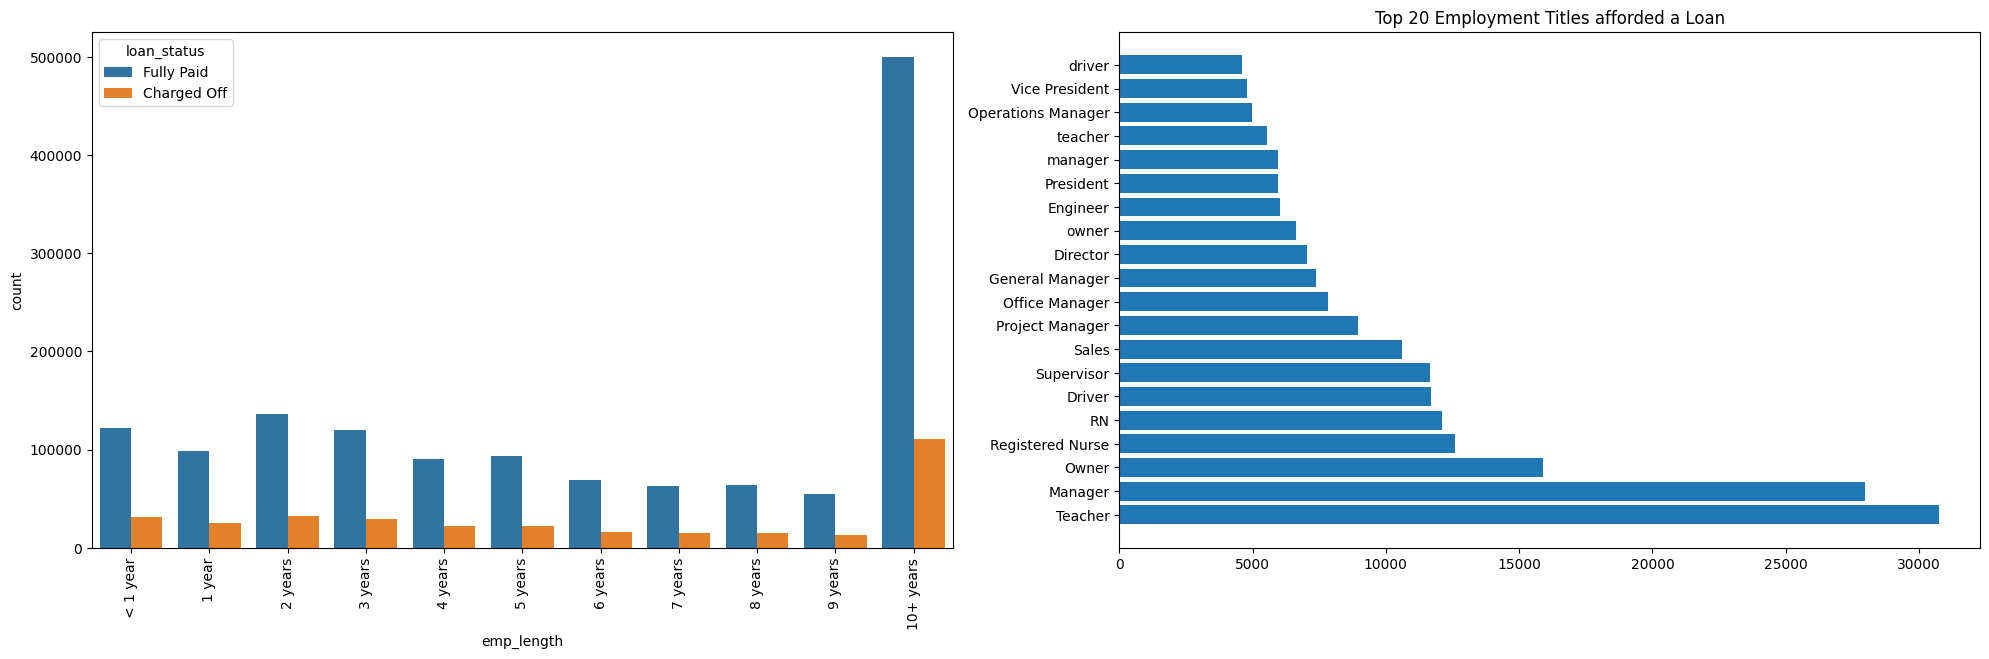

In [ ]:
# @title
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
g = sns.countplot(data=df, x='emp_length', hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(2, 2, 2)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])
plt.title("Top 20 Employment Titles afforded a Loan")
plt.tight_layout()

Borrowers with more than 10 years of working are more likely to pay off loans. Thus, teacher represents a stable job with long-term employment, and they most likely afford the loans. Meanwhile, driver shows a less stable employment so they can't afford loan as well as other top 20 employment titles

### `purpose` and `title`


In [12]:
df['purpose'].value_counts()

debt_consolidation    1063459
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

In [13]:
df['title'].value_counts()

Debt consolidation                          941169
Credit card refinancing                     366391
Home improvement                            111152
Other                                       102322
Major purchase                               36294
                                             ...  
Consolidating Debt for a Stable New Year         1
Rent and Capital One Payoff                      1
credit card repaymet                             1
Debt Pay-off Loan                                1
Credit Card/Auto Repair                          1
Name: title, Length: 61685, dtype: int64

[Text(0, 0, 'credit_card'),
 Text(1, 0, 'car'),
 Text(2, 0, 'small_business'),
 Text(3, 0, 'other'),
 Text(4, 0, 'wedding'),
 Text(5, 0, 'debt_consolidation'),
 Text(6, 0, 'home_improvement'),
 Text(7, 0, 'major_purchase'),
 Text(8, 0, 'medical'),
 Text(9, 0, 'moving'),
 Text(10, 0, 'vacation'),
 Text(11, 0, 'house'),
 Text(12, 0, 'renewable_energy'),
 Text(13, 0, 'educational')]

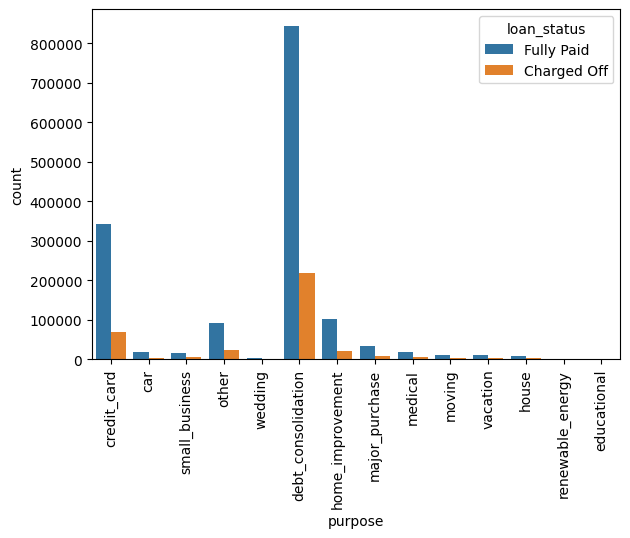

In [ ]:
# @title
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
g = sns.countplot(data=df, x='purpose', hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## Dealing with missing values

### What does `NaN` mean?
#### Employment title and employment length
- In the context of employment length and employment title, NaN may indicate that the borrower is not currently being employed. That doesn't mean that borrower couldn't afford a loan, as they might receive money from some income sources, such as their family's income. Therefore we would look into null values of the employment length.
- As a lot of those without employment title own mortgage and have high annual income, let's not drop the null values here. Instead, map them to 0 years to indicate that they are not currently employed. There will be no missing values left for `emp_length`.

#### Annual income
- In terms of Annual income, NaN presents a lack of proof that a borrower is capable of paying the installments. Thus, examine the NaN values in `annual_inc` closely.

#### Purpose & title
- in terms of `purpose` and `title`, if a borrower doesn't specify the purpose to borrow the loan, it may state that it's not that trustworthy to lend the loan to this borrower.

#### Earliest credit line
- Earliest credit line refers to the date when the borrower's first credit account was opened.
- A lender takes this indicator into account to see your credit score history and evaluate creditworthiness. If the information about `earliest_cr_line` is missing, the lender might not be confidentas much to give you a loan since they have an incomplete picture of the credit history.
- However, it is not a factor that directly affects the ability in qualifying for a loan. The lender might consider other factors to determine.

#### Debt-to-income ratio (DTI)
- This is an indicator measuring the ability in managing the monthly payment to pay off loans.
- DTI = (all monthly debt payment) / (gross monthly income)
- A lower DTI indicates that a borrower earns more grossly monthly income and has less debt to manage => positive impact on credit score => candidates for loan approval.
- Meanwhile a higher DTI shows that the borrower earns less but potentially has more debts to manager => negative impact on credit score => less likely to be qualified for a loan.
- DTI is a very important indicator, directly affecting the ability of qualifying for a loan. Thus, missing DTI values should be addressed carefully. We would plot a distribution to visualize the DTI values of each record, and see how we can deal with the missing values.

#### Title
- We notice a pattern between `purpose` and `title` as `title` is just a subset of `purpose`. It describes the purpose in detail, while the general purpose is good enough. Therefore, we will remove this feature column.

In [14]:
def null_value_counts(data):
  '''
    Count null values in each feature column
  '''
  data_null = {}
  for col in data.columns:
    num_null = data[col].isna().sum()
    data_null[col] = [num_null]
  data_null = pd.DataFrame(data_null, index=[0]).T
  data_null = data_null.rename(columns = {0: 'Number of NaN values'})
  return data_null

In [15]:
df = df.dropna(how='all')             # first drop records whose column values are all NaN

### `emp_length`

In [ ]:
df['emp_length'] = df['emp_length'].fillna('0 years')         # replace all missing values in emp_length with "0 years"

### `emp_title`

In [ ]:
df['emp_title'] = df['emp_title'].fillna('OTHER')         # replace missing values in emp_title with OTHER

### `title`

In [ ]:
df['title'] = df['title'].fillna('OTHER')                 # replace missing values in title with OTHER

### `dti`
We would perform mean imputing for the missing values.

In [ ]:
dti_mean = df['dti'].mean()
df['dti'] = df['dti'].fillna(dti_mean)

### `mort_acc` & `pub_rec_bankruptcies`
Here we wouldn't apply the same logic of mean imputing the missing values, as the columns contain the number of mortgage accounts and number of public record bankruptcies, which must be of `int` type.

- We can still apply the mean imputing method, but then round up the mean to the nearest integer.

In [ ]:
mort_acc_mean = df['mort_acc'].mean().round()
pub_rec_bankrupt_mean = df['pub_rec_bankruptcies'].mean().round()

df['mort_acc'] = df['mort_acc'].fillna(mort_acc_mean)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(pub_rec_bankrupt_mean)

### `revol_util`

In [ ]:
rev_util_mean = df['revol_util'].mean()
df['revol_util'] = df['revol_util'].fillna(rev_util_mean)

Now if you reload the table showing the NaN values in each column, all NaN values have either been removed or imputed.

In [22]:
df_null = null_value_counts(df)
df_null

,Number of NaN values
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


It does not make sense that a person has 2.67 open credit lines, or 3.69 mortgage accounts, so we should convert the existing float data type into int.

In [ ]:
df['open_acc'] = df['open_acc'].astype(int)
df['pub_rec'] = df['pub_rec'].astype(int)
df['total_acc'] = df['total_acc'].astype(int)
df['mort_acc'] = df['mort_acc'].astype(int)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(int)

## Numerical features
- `loan_amnt`, `int_rate`, `installment`, `annual_inc`, `dti`, `revol_bal`, `revol_util`

(0.0, 100.0)

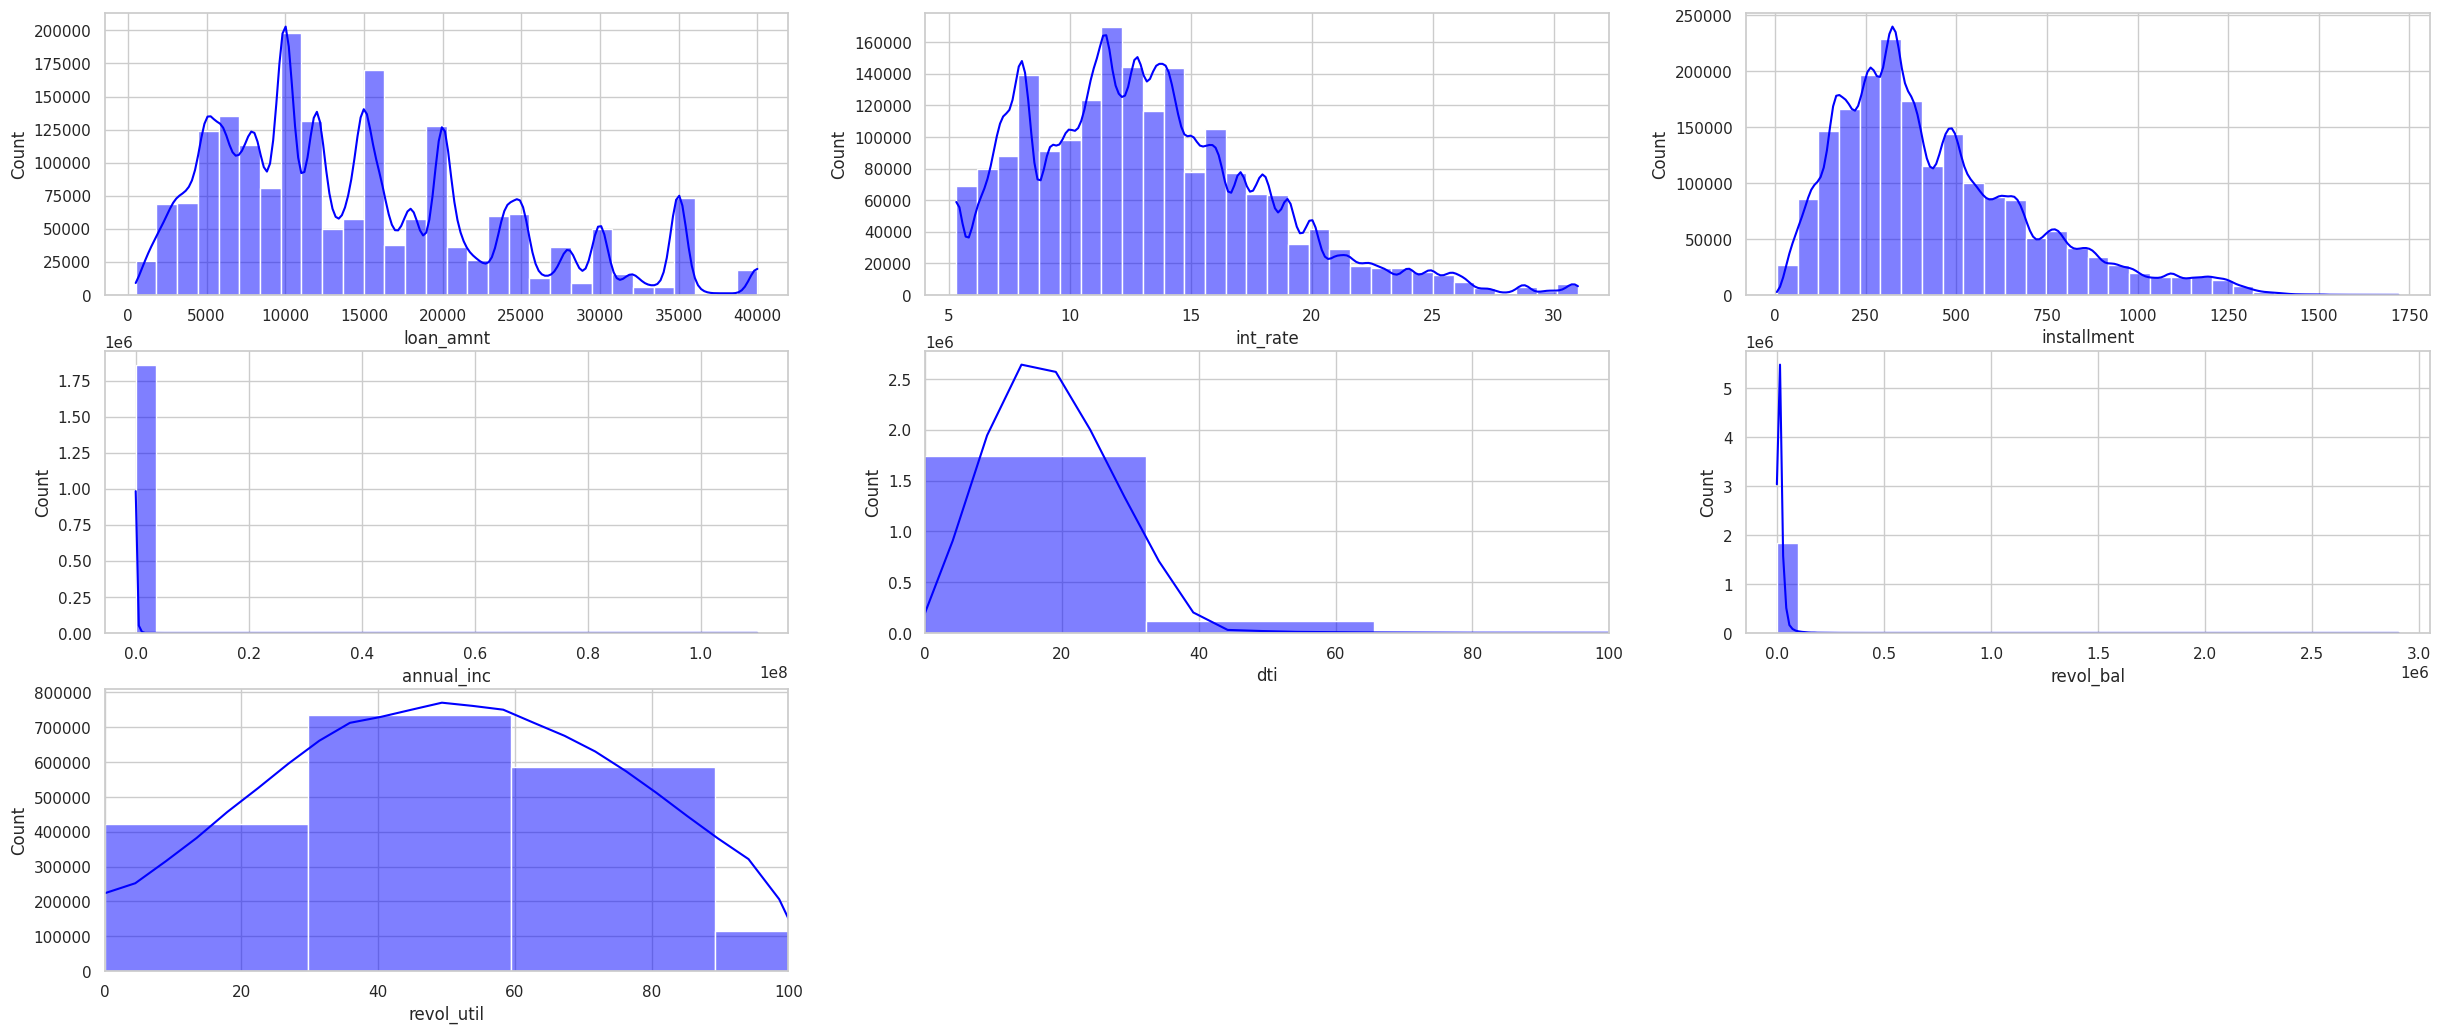

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=df , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

### Addressing inappropriate values
- DTI: It is the Debt-to-Income ratio, calculated by: all monthly debt payments / gross monthly income. It does not make sense if a DTI ratio is negative, as a person doesn't have a negative monthly debt payments or negative income. It might have been a typing error, so we will remove all negative values in `dti`.

In [24]:
def count_negative_values(data):
  '''
    Count the number of negative values in each feature
  '''
  counts = []
  neg_data = {}
  for i in data.columns:
    if data[i].dtype == float:
      total = (data[i] < 0).sum()
      neg_data[i] = [total]
  neg_df = pd.DataFrame(neg_data).T
  neg_df = neg_df.rename(columns={0: "Number of negative values"})
  return neg_df

In [25]:
neg_df = count_negative_values(df)
neg_df

,Number of negative values
loan_amnt,0
int_rate,0
installment,0
annual_inc,0
dti,2
revol_bal,0
revol_util,0


In [26]:
df = df.drop(df[df['dti'] < 0].index)                     # remove all records with a negative DTI ratio

We visualize the correlation among numerical features.

<ipython-input-27-651235015452>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')


<Axes: >

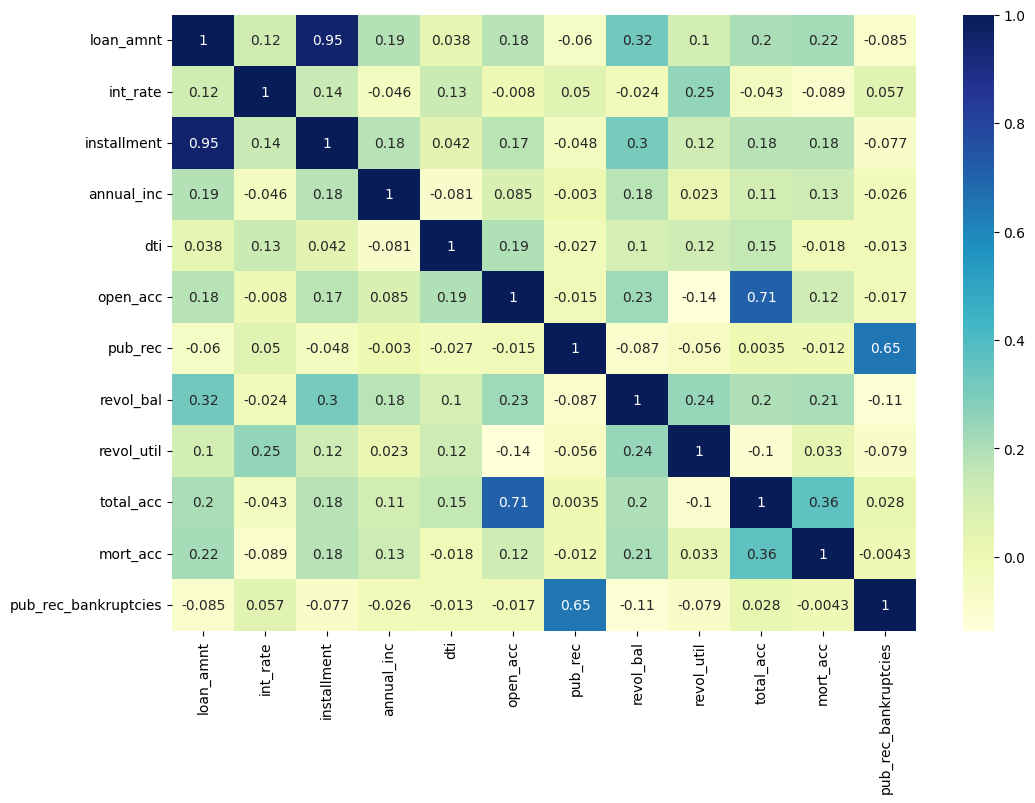

In [27]:
# correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')

We observe that `loan_amnt` and `installment` share a very high correlation, so there may be potential duplicate information between the 2 features. We will take a closer look at them.

## How does each feature affect the target variable?

###`loan_amnt` & `installment`

<Axes: xlabel='installment', ylabel='Count'>

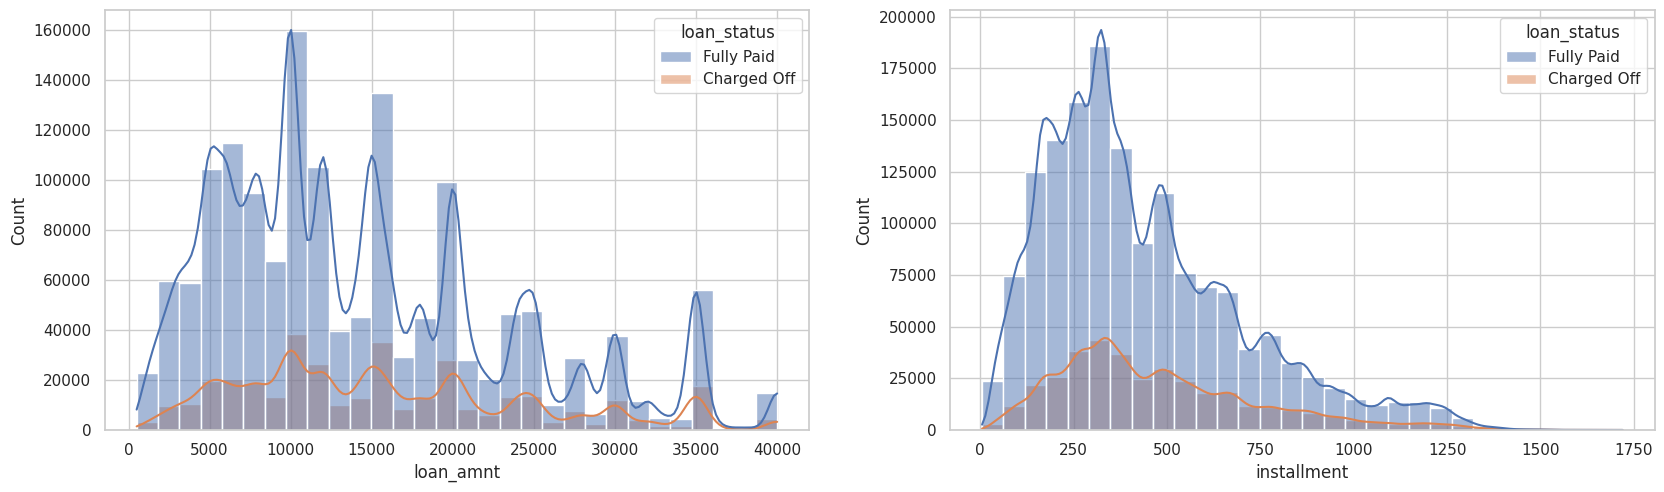

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='loan_amnt', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='installment', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='installment', ylabel='loan_status'>

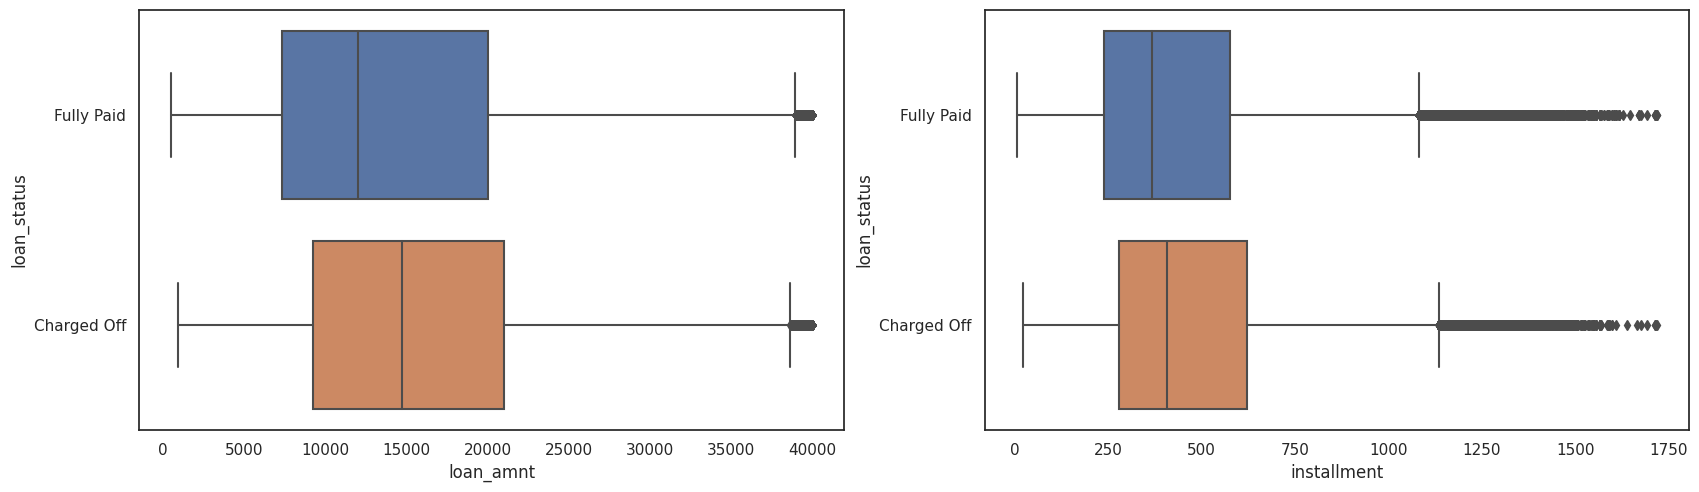

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="white")

plt.subplot(2, 2, 1)
sns.boxplot(x='loan_amnt', y='loan_status', data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='installment', y='loan_status', data=df)

The average loan amount among all customers is:

In [28]:
loan_amnt_avg = df['loan_amnt'].mean()
print(f"Average Loan Amount: {loan_amnt_avg.round()}")

Average Loan Amount: 14588.0


###`annual_inc` & `int_rate`

We want to see that with the annual income, how many people approved and did not approve for a loan, and the same with interest rate.

<Axes: xlabel='int_rate', ylabel='Count'>

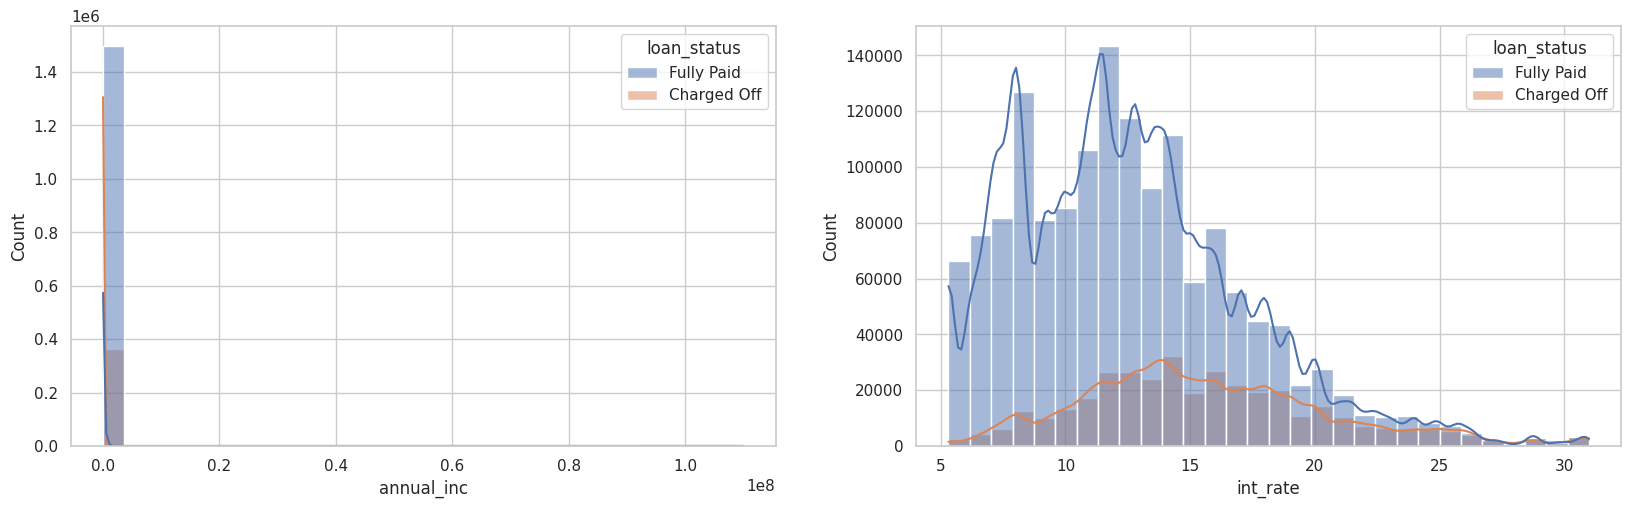

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='annual_inc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='int_rate', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='int_rate', ylabel='loan_status'>

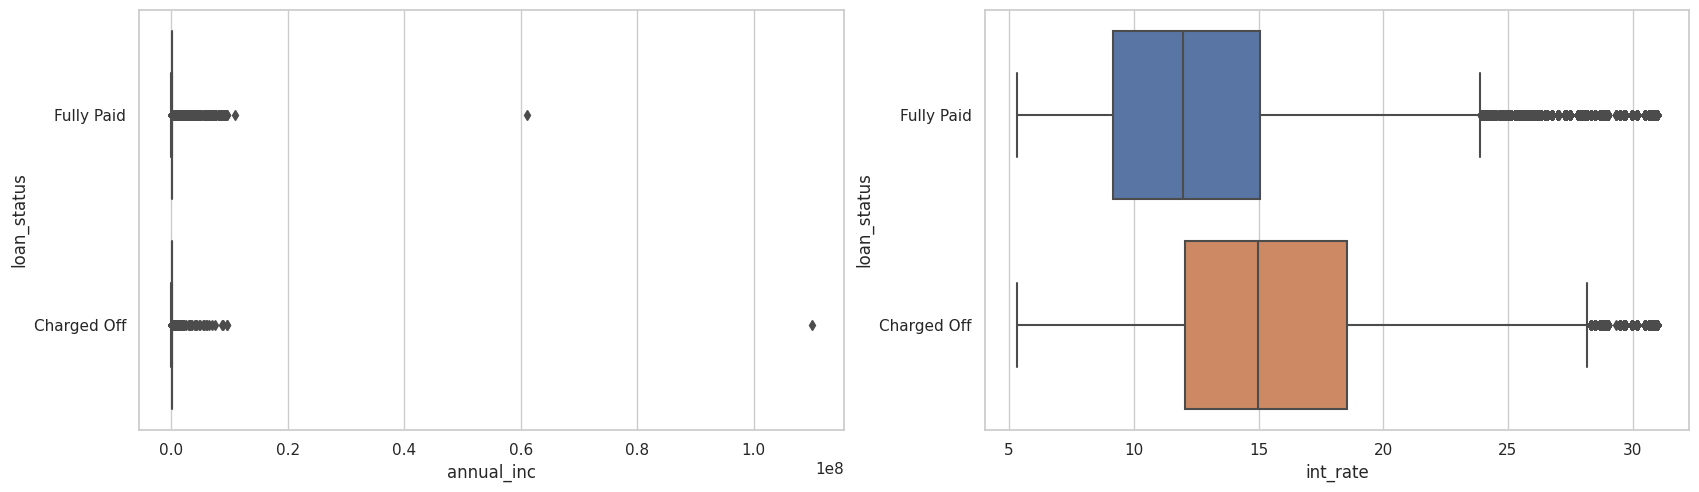

In [ ]:
# @title
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='annual_inc', y='loan_status', data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='int_rate', y='loan_status', data=df)

#### Insight
In the aspect of lenders, they consider an annual income of several times higher than the loan amount to mitigate the risk of the borrower being charged off. A threshold of an annual income of 3 times higher than the loan amount should be reasonable. Thus we want to learn that how many people in this range can afford a loan.

In [29]:
annual_inc_df = df[(df['annual_inc'] >= 3 * loan_amnt_avg) & (df['annual_inc'] <= 200000)]    # set the range to a more reasonable annual income range

[Text(0.5, 1.0, 'Loan Status of Annual Income 3 times higher than the average loan amount')]

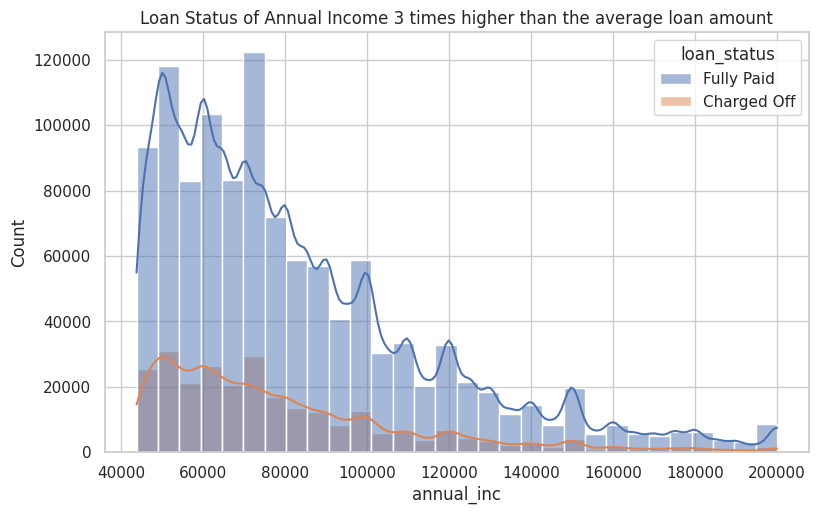

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='annual_inc', hue='loan_status', data=annual_inc_df, bins=30, kde=True, color='blue').set(title='Loan Status of Annual Income 3 times higher than the average loan amount')

Borrowers who earned an average annual income between 50,000 and 80,000 are more likely to pay off the loan.

###`grade` & `sub_grade`

`grade`: the assigned loan grade. Each grade corresponds with a certain level of risk while lending to that corresponded person.

`sub_grade`: the assigned loan sub grade. Each sub grade corresponds with a certain level of risk.

<ipython-input-40-18014df90fcd>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'B2'),
 Text(1, 0, 'C4'),
 Text(2, 0, 'C5'),
 Text(3, 0, 'C1'),
 Text(4, 0, 'B5'),
 Text(5, 0, 'A4'),
 Text(6, 0, 'E1'),
 Text(7, 0, 'F2'),
 Text(8, 0, 'C3'),
 Text(9, 0, 'B1'),
 Text(10, 0, 'D1'),
 Text(11, 0, 'A1'),
 Text(12, 0, 'B3'),
 Text(13, 0, 'B4'),
 Text(14, 0, 'C2'),
 Text(15, 0, 'D2'),
 Text(16, 0, 'A3'),
 Text(17, 0, 'A5'),
 Text(18, 0, 'D5'),
 Text(19, 0, 'A2'),
 Text(20, 0, 'E4'),
 Text(21, 0, 'D3'),
 Text(22, 0, 'D4'),
 Text(23, 0, 'F3'),
 Text(24, 0, 'E3'),
 Text(25, 0, 'F4'),
 Text(26, 0, 'F1'),
 Text(27, 0, 'E5'),
 Text(28, 0, 'G4'),
 Text(29, 0, 'E2'),
 Text(30, 0, 'G3'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G1'),
 Text(33, 0, 'F5'),
 Text(34, 0, 'G5')]

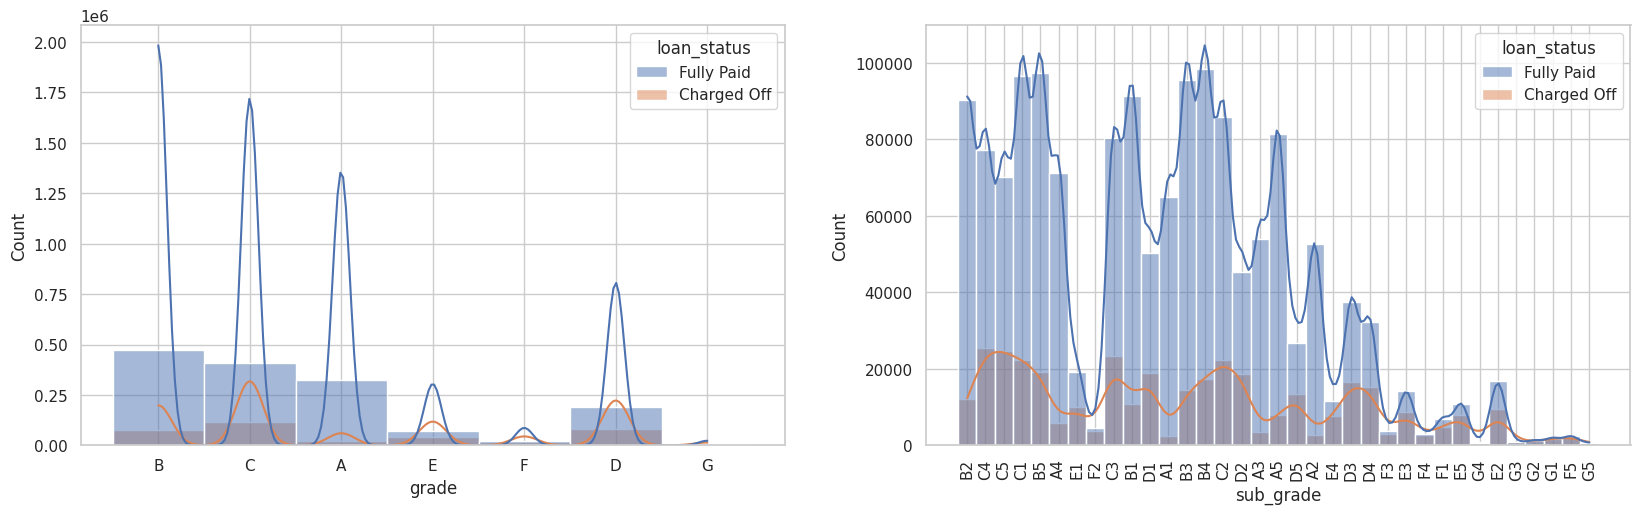

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='grade', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
g = sns.histplot(x='sub_grade', hue='loan_status', data=df, bins=30, kde=True, color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

We observe that there are not many people at grade F and G that pay back, and that's illustrated in more detail in the `sub_grade` plot.

<ipython-input-41-dafb3f7ad454>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'F2'),
 Text(1, 0, 'F3'),
 Text(2, 0, 'F4'),
 Text(3, 0, 'F1'),
 Text(4, 0, 'G4'),
 Text(5, 0, 'G3'),
 Text(6, 0, 'G2'),
 Text(7, 0, 'G1'),
 Text(8, 0, 'F5'),
 Text(9, 0, 'G5')]

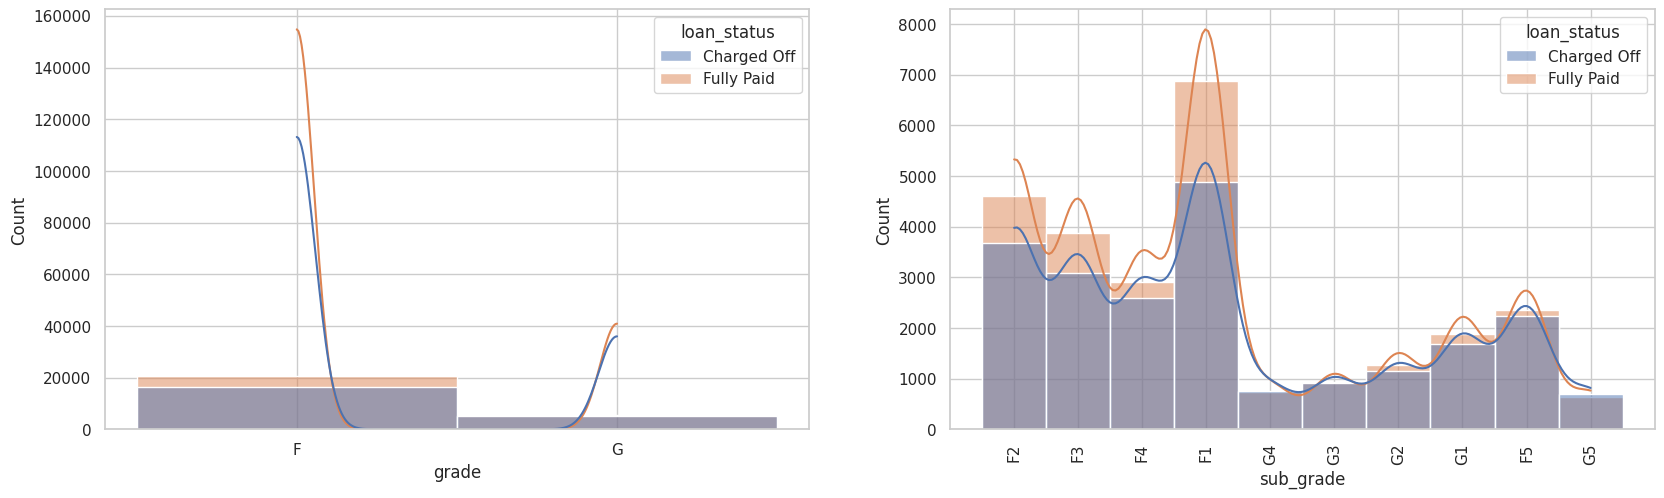

In [ ]:
grade_df = df[(df['grade'] == 'F') | (df['grade'] == 'G')]

# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='grade', hue='loan_status', data=grade_df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
g = sns.histplot(x='sub_grade', hue='loan_status', data=grade_df, bins=30, kde=True, color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

###`home_ownership` & `verification_status` & `term` & `purpose`

`home_ownership`: The home ownership status provided by the borrower.

`verification_status`: indicates if the income was verified by Loaning Club.

`term`: the number of payments on the loan, depending on the term of the loan (36 or 60 months).

`purpose`: the category provided by the borrower for the loan request.

What are the possible values for each of these features?

In [30]:
df['home_ownership'].value_counts()

MORTGAGE    918026
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

In [31]:
df['verification_status'].value_counts()

Source Verified    734067
Not Verified       588360
Verified           537902
Name: verification_status, dtype: int64

In [32]:
df['term'].value_counts()

 36 months    1393298
 60 months     467031
Name: term, dtype: int64

In [33]:
df['purpose'].value_counts()

debt_consolidation    1063457
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

[Text(0, 0, 'credit_card'),
 Text(1, 0, 'car'),
 Text(2, 0, 'small_business'),
 Text(3, 0, 'other'),
 Text(4, 0, 'wedding'),
 Text(5, 0, 'debt_consolidation'),
 Text(6, 0, 'home_improvement'),
 Text(7, 0, 'major_purchase'),
 Text(8, 0, 'medical'),
 Text(9, 0, 'moving'),
 Text(10, 0, 'vacation'),
 Text(11, 0, 'house'),
 Text(12, 0, 'renewable_energy'),
 Text(13, 0, 'educational')]

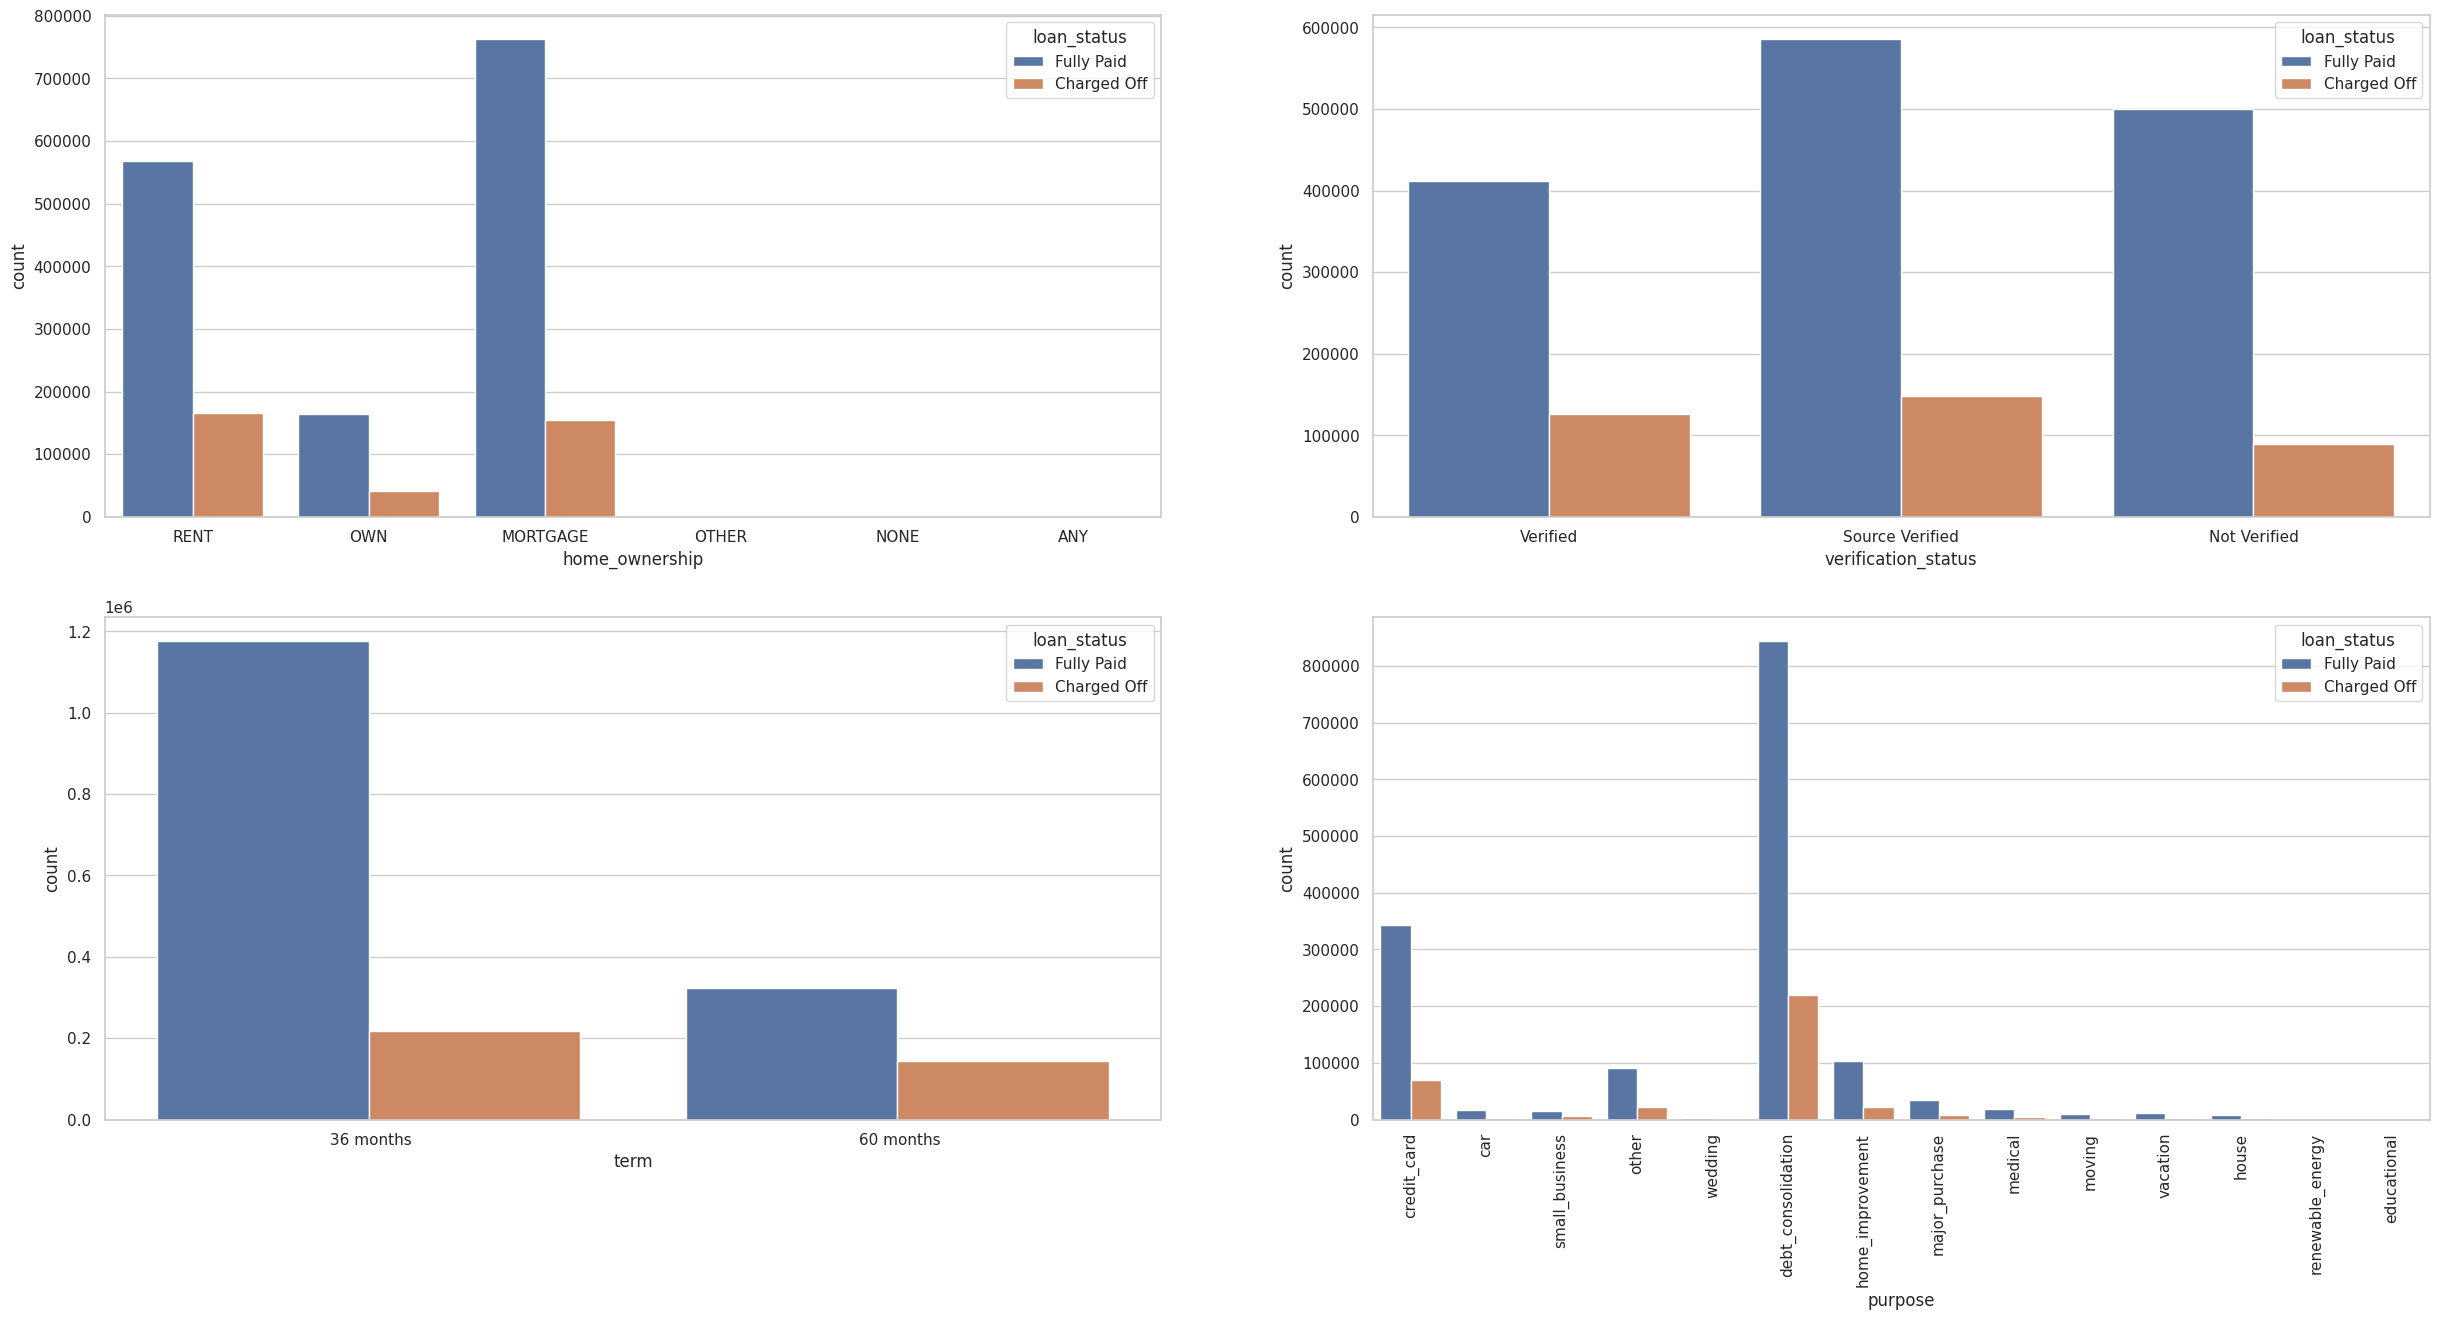

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(4, 2, 1)
sns.countplot(x='home_ownership', hue='loan_status', data=df)

plt.subplot(4, 2, 2)
sns.countplot(x='verification_status', hue='loan_status', data=df)

plt.subplot(4, 2, 3)
sns.countplot(x='term', hue='loan_status', data=df)

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', hue='loan_status', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

Most people who afford the loan was those who own mortgage, have a verified source of income, in a 36-month loan term, and have a purpose of debt consolidation. This is unsurprising as a short term loan has significantly lower interest rate, so it's easier to be paid off than the long term, 60-month loan.

###`dti`

`dti`: the debt-to-income ratio.

DTI = (all monthly debt payment) / (gross monthly income)

=> the lower DTI, the more positive one's credit score is => more likely to qualify for a loan.

<Axes: xlabel='dti', ylabel='Count'>

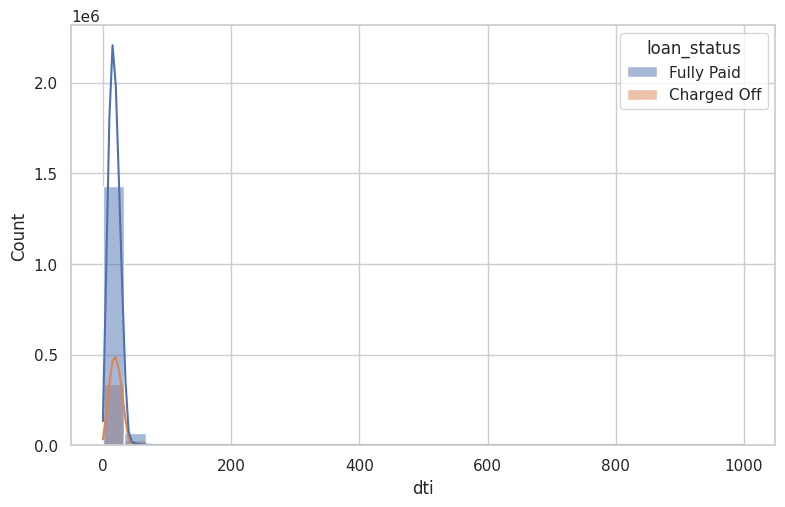

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='dti', hue='loan_status', data=df, bins=30, kde=True, color='blue')

In [34]:
print("DTI max: ",df['dti'].max())

DTI max:  999.0


<Axes: xlabel='dti', ylabel='loan_status'>

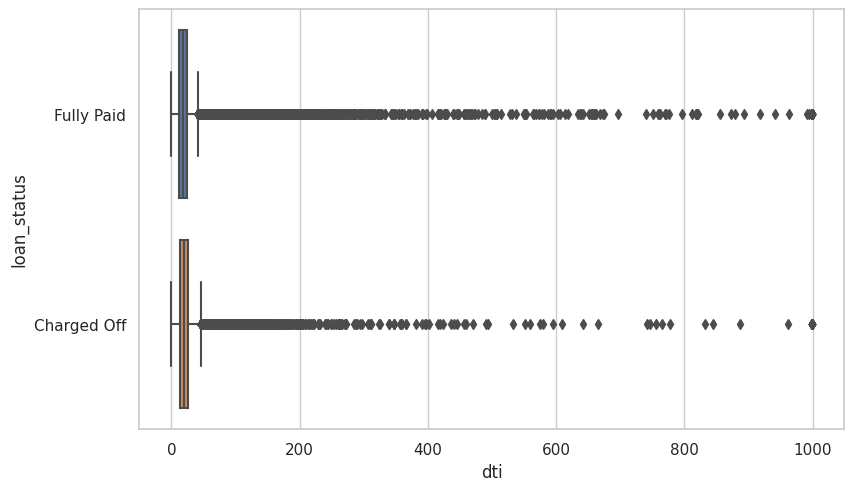

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="dti", y="loan_status", data=df)

#### Insight
By convention, a DTI of less than or equal to 43% might be a good threshold that all borrowers with a DTI lower than this threshold are more likely to pay off the loan.

###`revol_bal` & `revol_util`


`revol_bal`: the total revolving balance

`revol_util`: the revolving utilization rate

<Axes: xlabel='revol_util', ylabel='Count'>

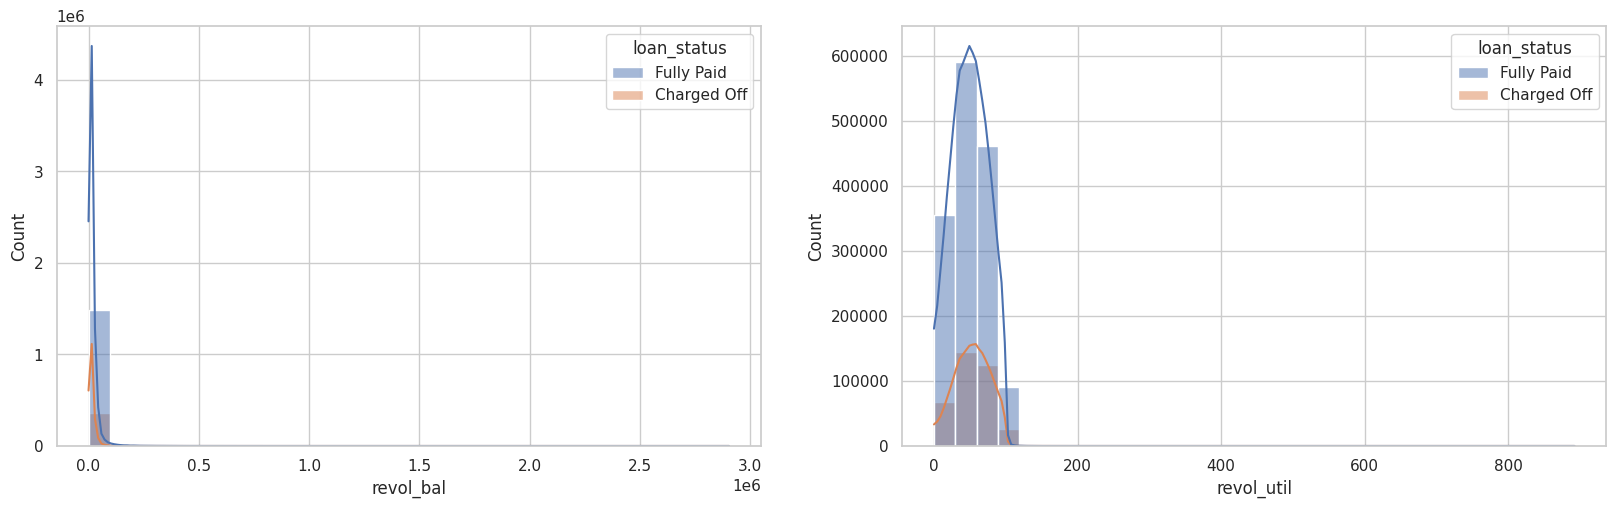

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='revol_bal', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='revol_util', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='revol_util', ylabel='loan_status'>

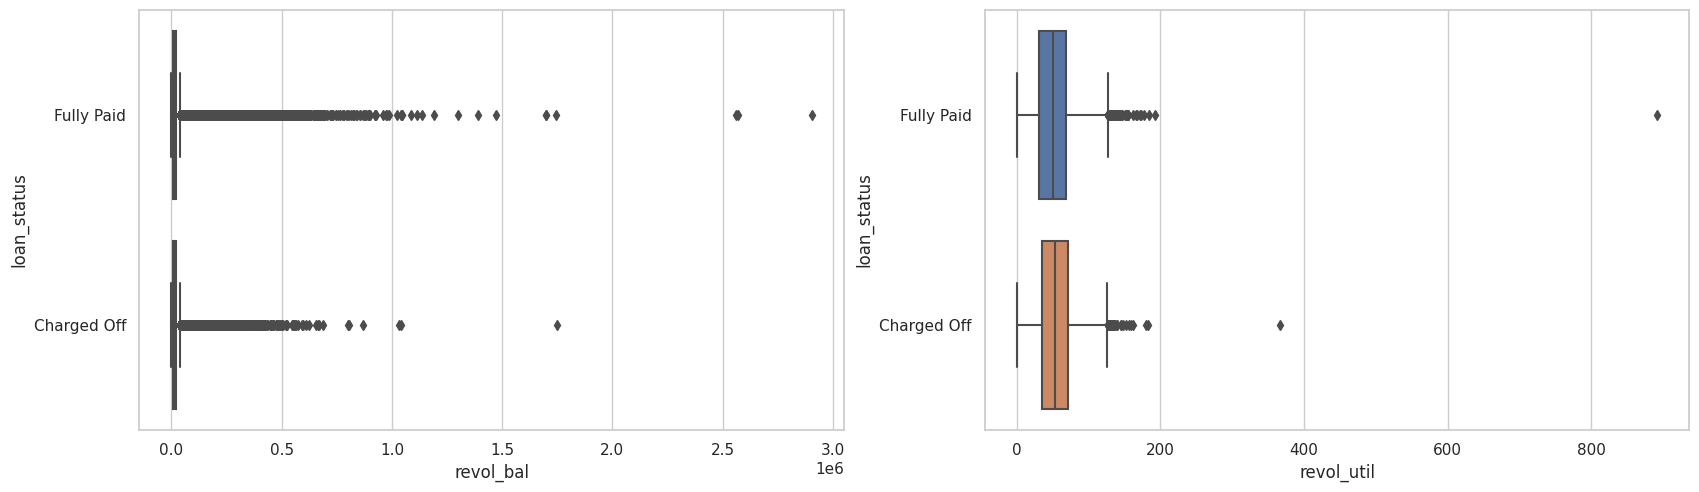

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="revol_bal", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='revol_util', y='loan_status', data=df)

#### Insight
By convention, a revolving utilization rate of less than or equal to 30% is a good threshold. All borrowers with a `revol_util` rate below this threshold have a more positive credit score and more likely to pay back the loan.

In [35]:
revol_util_df = df[(df['revol_util'] <= 30)]

[Text(0.5, 1.0, 'Loan Status with revol utilization rate <= 30%')]

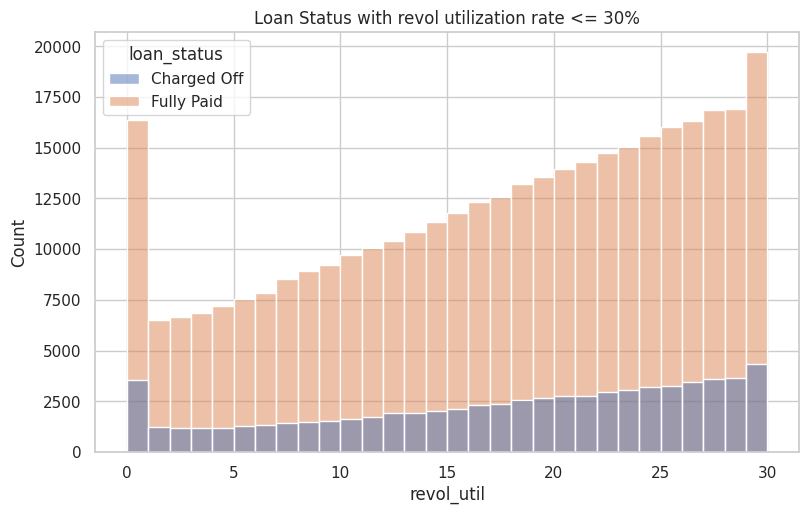

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='revol_util', hue='loan_status', data=revol_util_df, bins=30, color='blue').set(title="Loan Status with revol utilization rate <= 30%")

We observe that the lower the revolving utilization rate, the fewer people pay back the loan.

###`total_acc` & `open_acc` & `mort_acc`

`total_acc`: the total number of credit lines currently in borrower's credit file

`open_acc`: the number of open credit lines in the borrower's credit file

`mort_acc`: number of mortgage accounts

<Axes: xlabel='mort_acc', ylabel='Count'>

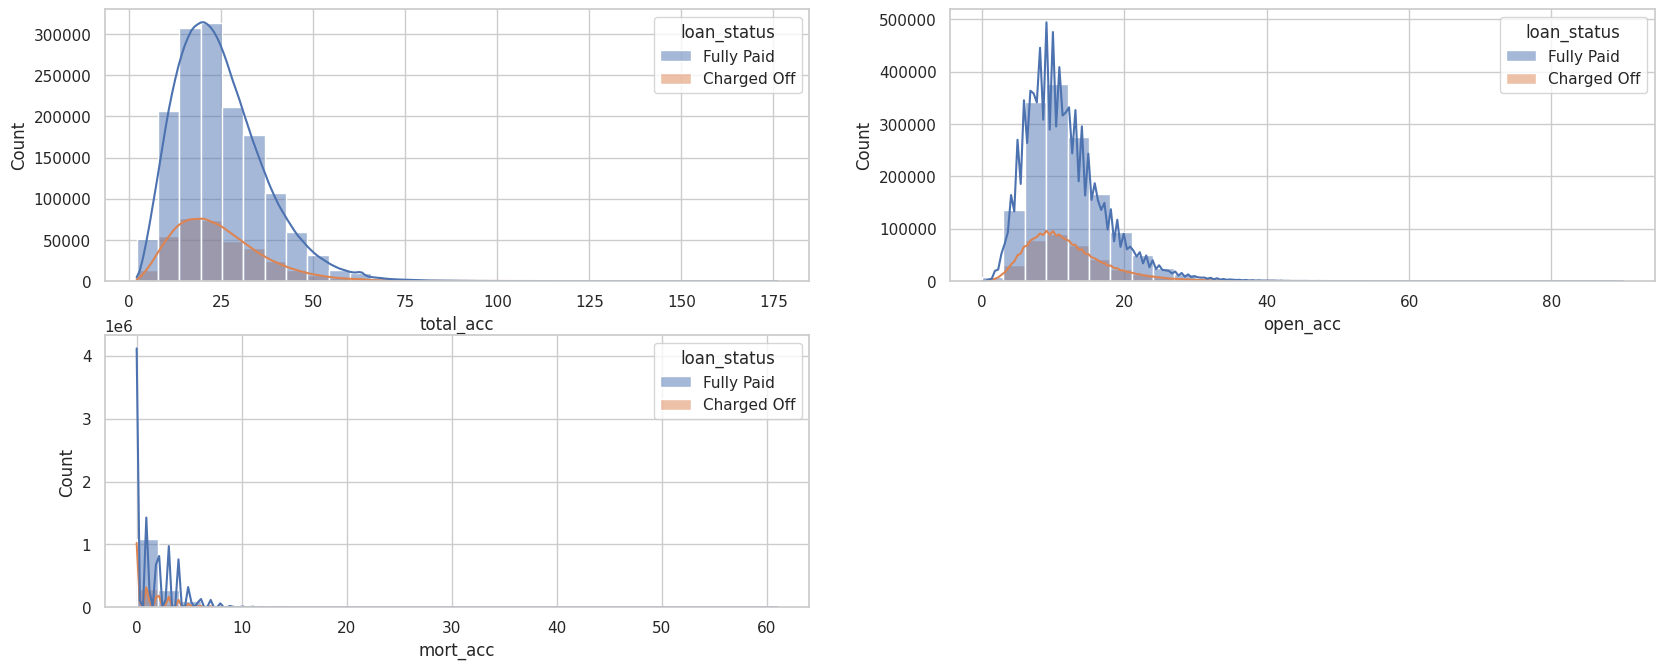

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(3, 2, 1)
sns.histplot(x='total_acc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(3, 2, 2)
sns.histplot(x='open_acc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(3, 2, 3)
sns.histplot(x='mort_acc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='mort_acc', ylabel='loan_status'>

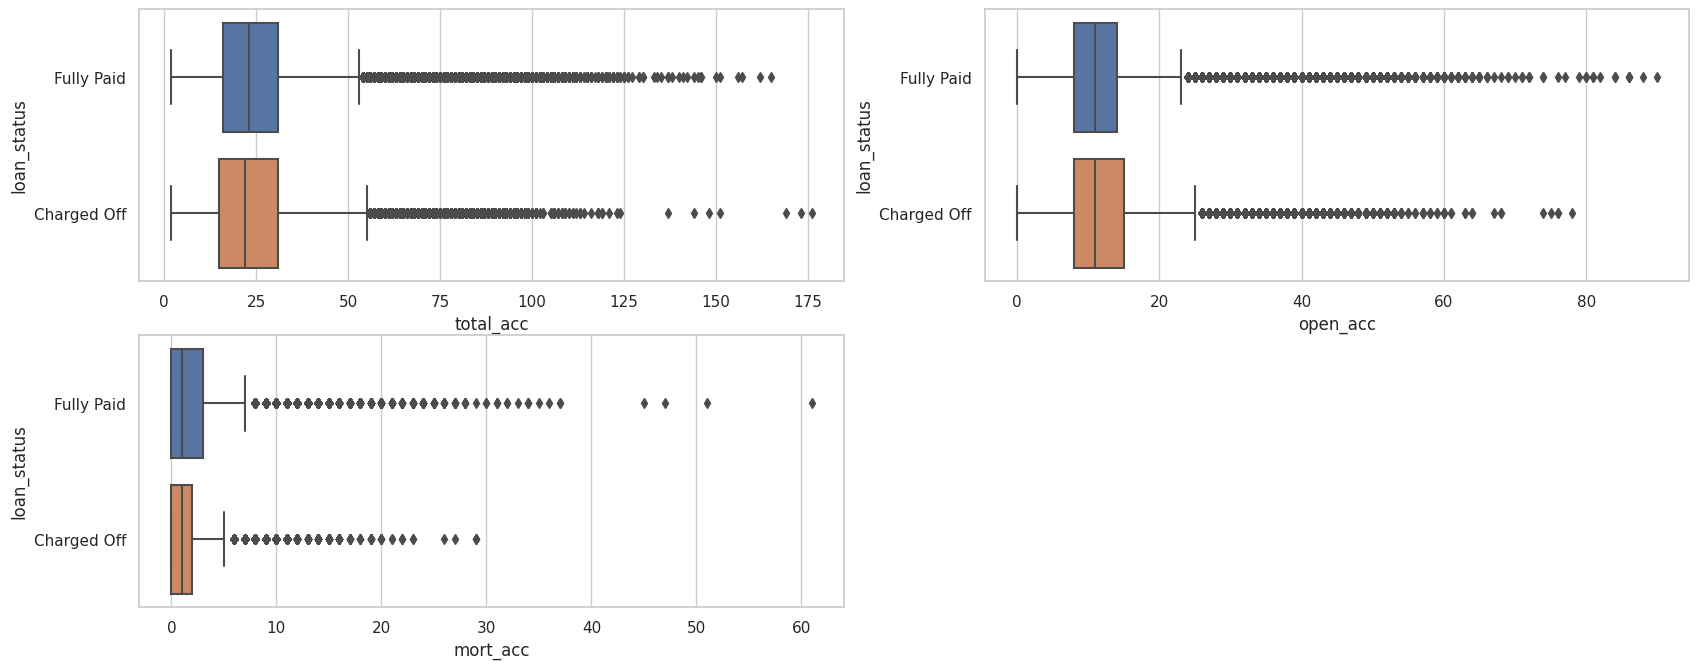

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(3, 2, 1)
sns.boxplot(x="total_acc", y="loan_status", data=df)

plt.subplot(3, 2, 2)
sns.boxplot(x="open_acc", y="loan_status", data=df)

plt.subplot(3, 2, 3)
sns.boxplot(x="mort_acc", y="loan_status", data=df)

#### Insight

Multiple open credit lines results in a lower credit utilization ratio, as many open credit lines increase the total credit available, and the owing balance can also spread across all credit accounts. This reduces the amount of loan debts compared to a single credit line.

While multiple open credit lines seem like a good indicator, too many credit lines contain risk. The borrower has access to a significant amount of credit, and they might potentially take on more debt than they can manage. Also, too many credit lines can affect their management on timely debt payment.

### `pub_rec` & `pub_rec_bankruptcies`

`pub_rec`: the number of derogatory public records

`pub_rec_bankruptcies`: the number of public record bankruptcies

In [36]:
print(f"Maximum number of public derogatory record: {df['pub_rec'].max()}")
print(f"Maximum number of public record bankruptcies: {df['pub_rec_bankruptcies'].max()}")

Maximum number of public derogatory record: 86
Maximum number of public record bankruptcies: 12


We should realize that any borrowers with a number of public derogatory record or public record bankruptcies more than 1 should be considered "red flags", as this significantly affects their credit score and ability to pay off loan debts since they already go bankrupt or have negative credit behavior.

<Axes: xlabel='pub_rec_bankruptcies', ylabel='Count'>

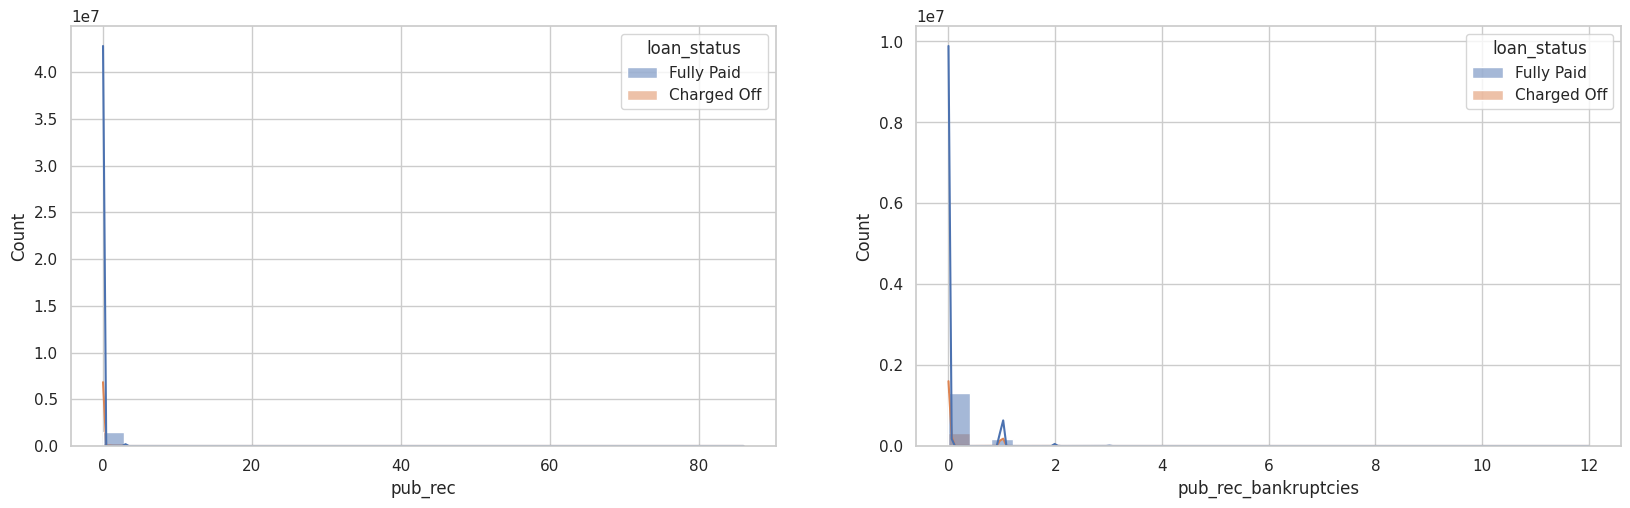

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='pub_rec', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='pub_rec_bankruptcies', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='pub_rec_bankruptcies', ylabel='loan_status'>

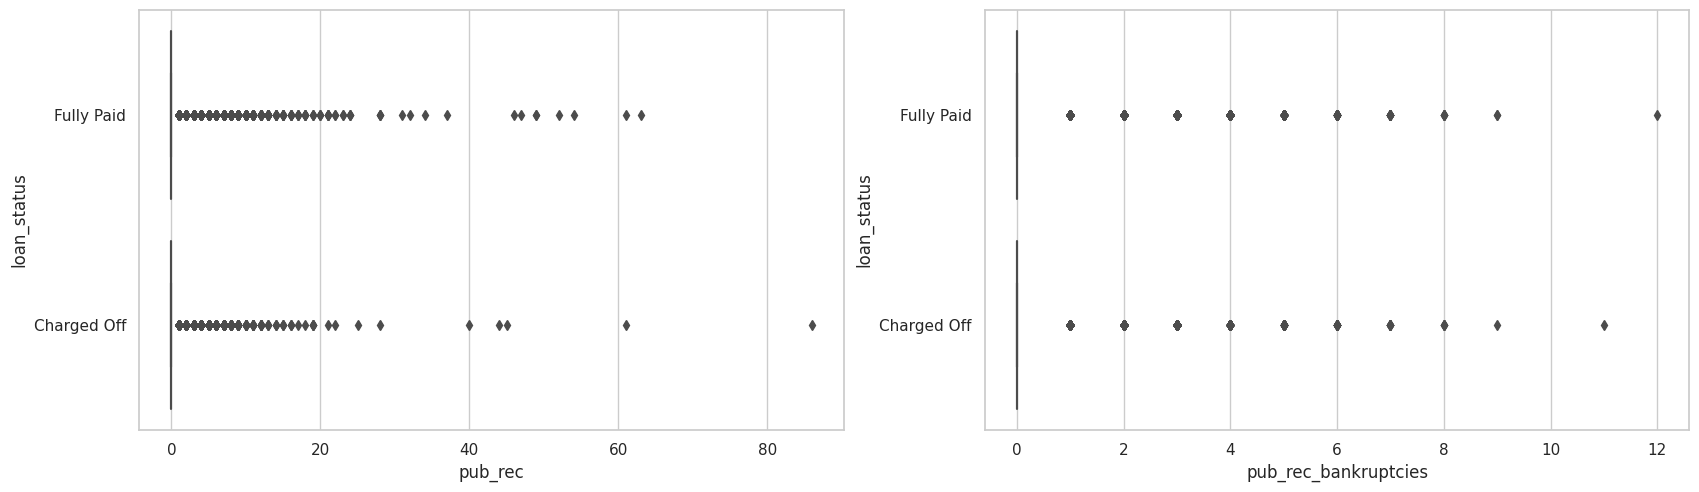

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="pub_rec", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x="pub_rec_bankruptcies", y="loan_status", data=df)

As most people has more than 1 public derogatory record and public record bankruptcies, we should convert any value greater than 1 to 1, and turn these `pub_rec` and `pub_rec_bankruptcies` into categorical variables containing binary values (0 for No, 1 for Yes).

In [37]:
def pub_rec(val):
  '''
    Map all pub_rec greater than 1 into 1
  '''
  if val > 1:
    return 1
  else:
    return val

def pub_rec_bankruptcies(val):
  '''
    Map all pub_rec_bankruptcies greater than 1 into 1
  '''
  if val > 1:
    return 1
  else:
    return val

In [38]:
df['pub_rec'] = df.pub_rec.map(pub_rec)
df['pub_rec_bankruptcies'] = df.pub_rec_bankruptcies.map(pub_rec_bankruptcies)

Now if we check the `pub_rec` and `pub_rec_bankruptcies` values, their possible values are only 0 and 1 (no records or existing records, binary categorical features).

In [39]:
df['pub_rec'].value_counts()

0    1552451
1     307878
Name: pub_rec, dtype: int64

In [40]:
df['pub_rec_bankruptcies'].value_counts()

0    1629536
1     230793
Name: pub_rec_bankruptcies, dtype: int64

Since we have converted `pub_rec` and `pub_rec_bankruptcies` into categorical features, we won't apply Tukey's Fence here since they don't contain outliers.

#### Insight
We observe that most borrowers has 0 derogatory public records, and 0 public record bankruptcies. We notice that borrowers with more than 1 public record bankruptcies should be considered "red flags": this significantly affects their credit score and the ability to qualify for future loans.

In [41]:
pub_rec_bankrupt_df = df[(df['pub_rec_bankruptcies'] > 1)]

[Text(0.5, 1.0, 'Loan Status of More than 1 Public Record Bankruptcies')]

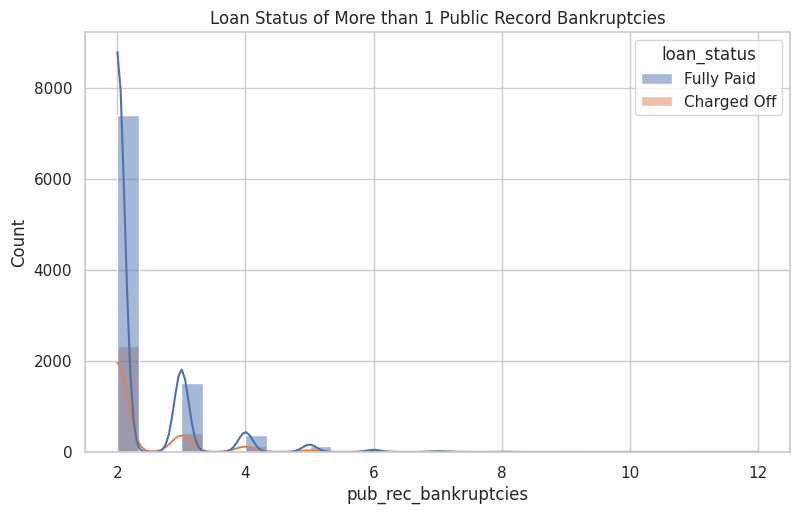

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='pub_rec_bankruptcies', hue='loan_status', data=pub_rec_bankrupt_df, bins=30, kde=True, color='blue').set(title="Loan Status of More than 1 Public Record Bankruptcies")

### `emp_title` & `emp_length`

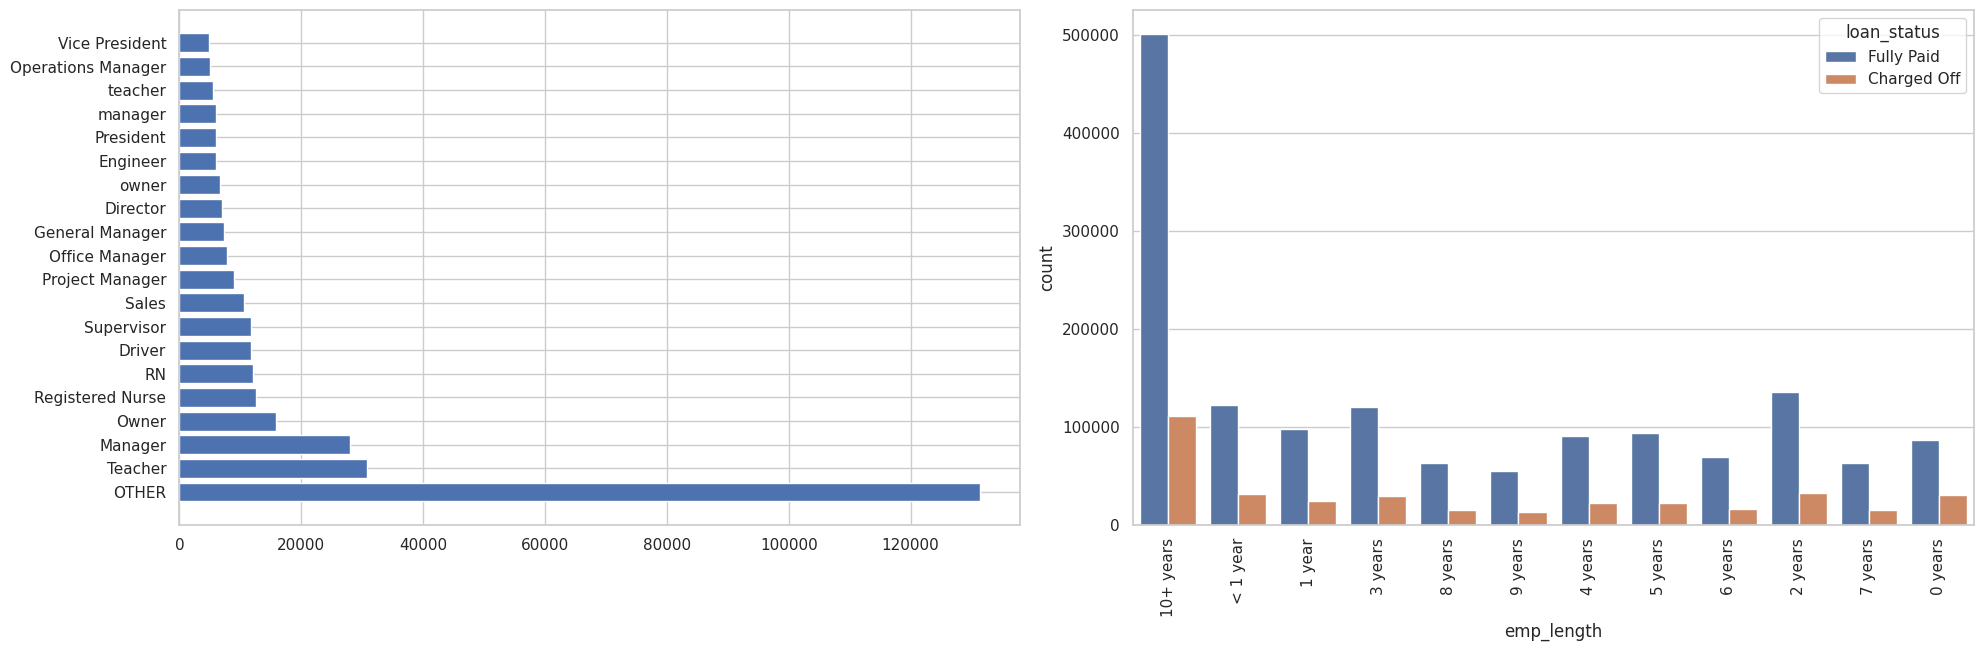

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])

plt.subplot(2, 2, 2)
g = sns.countplot(x='emp_length', hue='loan_status', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.tight_layout()

It shows that teachers and managers are more likely to pay off the loan as they are stable jobs, while obviously people who have been working for more than 10 years can pay off the loan debts easily.

### `issue_d` & `earliest_cr_line`

As the date in those features is in "YYYY-MM-DD" format, we should convert them to "YYYY", as it is not that important to consider each month or each day into the ability to pay off the loan.

In [42]:
df['issue_d'] = df['issue_d'].dt.year
df['earliest_cr_line'] = df['earliest_cr_line'].dt.year

In [43]:
print(f"Earliest issue date: {df['issue_d'].min()}")
print(f"Latest issue date: {df['issue_d'].max()}")
print(f"Earliest credit line date: {df['earliest_cr_line'].min()}")
print(f"Latest earliest credit line date: {df['earliest_cr_line'].max()}")

Earliest issue date: 2007
Latest issue date: 2020
Earliest credit line date: 1933
Latest earliest credit line date: 2017


<Axes: xlabel='earliest_cr_line', ylabel='Count'>

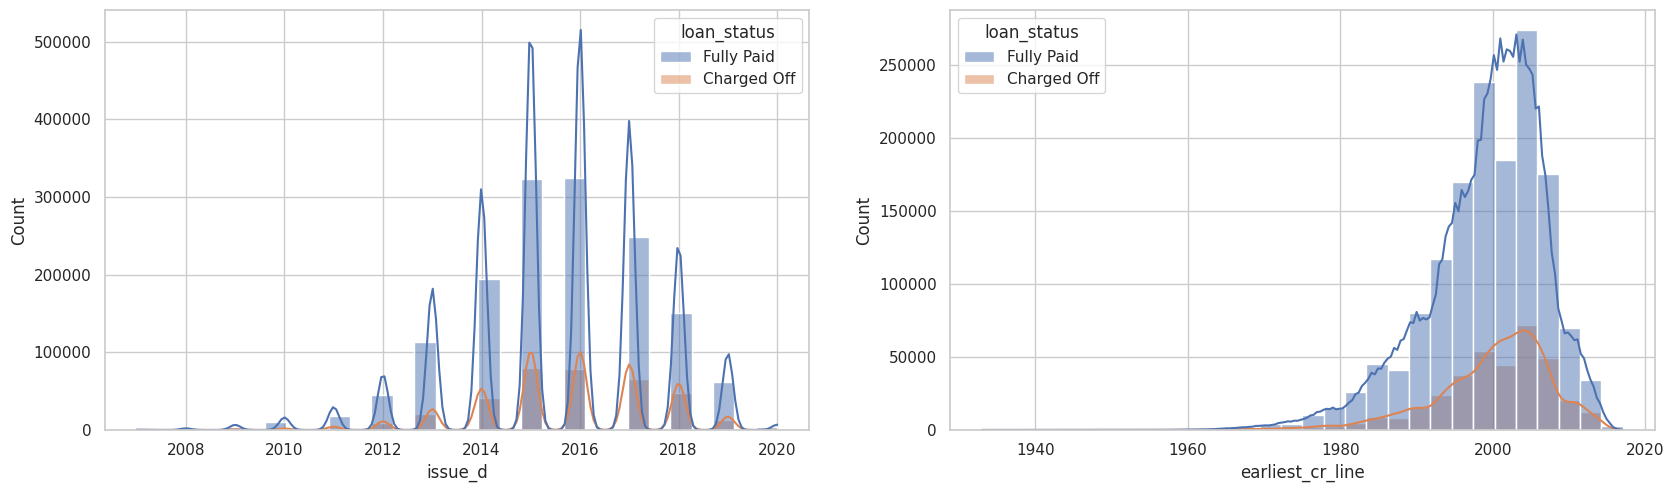

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='issue_d', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='earliest_cr_line', hue='loan_status', data=df, bins=30, kde=True, color='blue')

We observe that the company issues the loan the most around 2015-2016. Also, it shows an expected outburst in the earliest credit line opened in the 2000s, as it's the beginning of the technology era.

<Axes: xlabel='earliest_cr_line', ylabel='loan_status'>

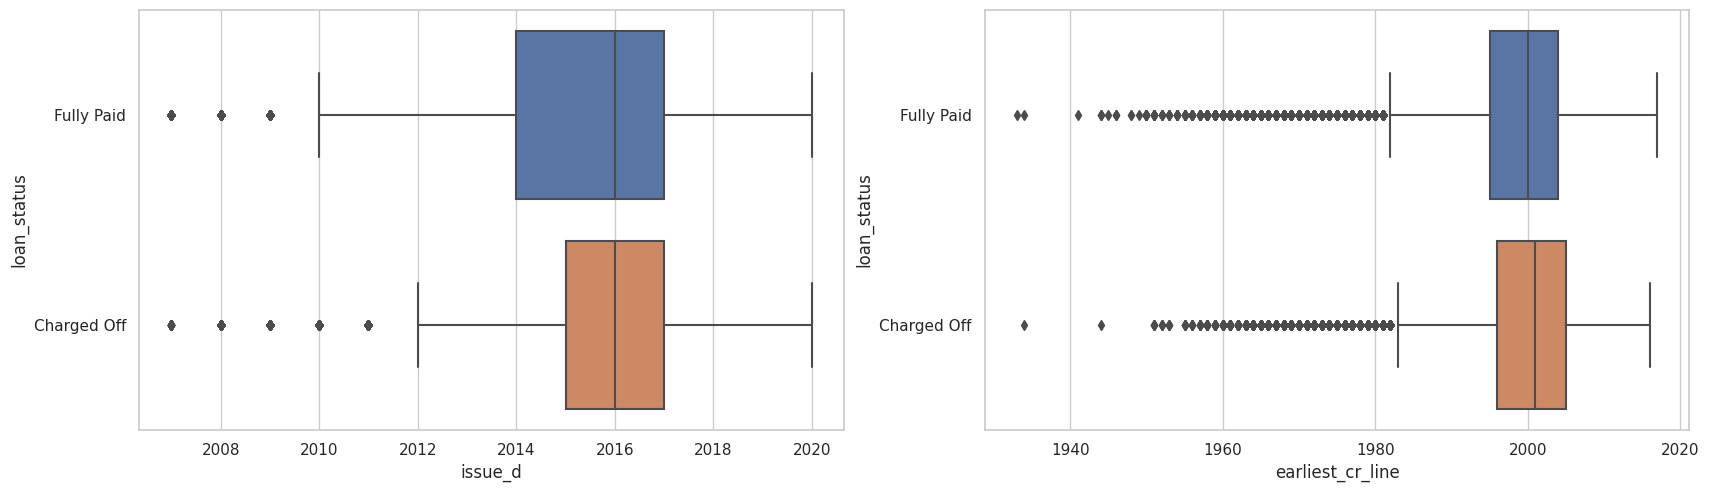

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="issue_d", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x="earliest_cr_line", y="loan_status", data=df)

#### Insight

We would not consider people who have the earliest credit line opened in the 1970s, as it will be difficult for any financial company to trace back all the credit behavior in that person's credit lines from a long time ago. Also, it is quite uneccessary to take those who were issued a loan before 2008 into account. Thus we would drop any data that passes these 2 thresholds.

### `initial_list_status` & `application_type`

- `initial_list_status`: the initial listing status of the loan. Possible values are W, F

  - W: whole
  - F: fractional

- `application_type`: indicates whether a loan is an individual application or a joint application (two co-borrowers)

Before plotting, we would assume that people with joint application and more mortgage accounts are more likely to pay off the loan. Let's see what happens.

<Axes: xlabel='application_type', ylabel='count'>

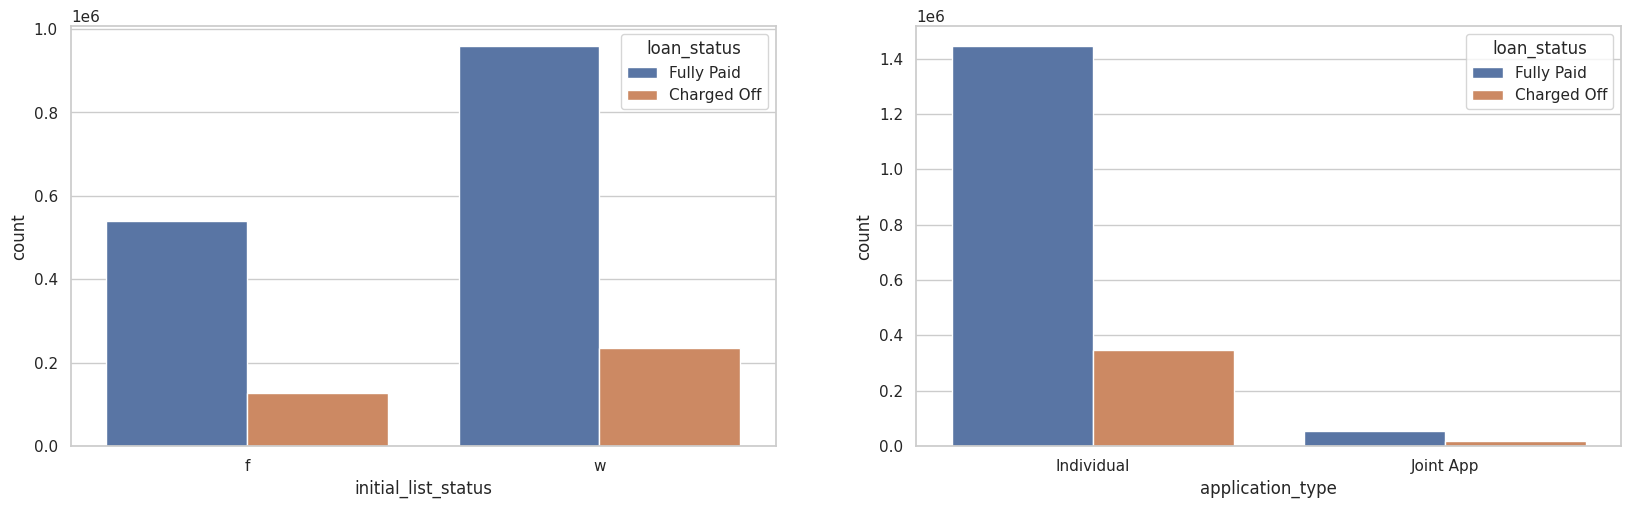

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.countplot(x='initial_list_status', hue='loan_status', data=df)

plt.subplot(2, 2, 2)
sns.countplot(x='application_type', hue='loan_status', data=df)

There are more borrowers whose initial list status of W. They are more likely to pay off the loan. Also, most borrower applies for individual loan.

# Data Preprocessing

## Outlier

### Tukey Fence & `annual_inc` & `installment` outliers

We observe there are still too many outliers in `annual_inc` (87826). If we decide to remove those outliers, we might lose too much information. Furthermore, we can visualize there are some extreme outliers, and the traditional IQR method may not be able to capture them. We apply an alternative, more flexible IQR method called Tukey's Fence.

In [44]:
def tukey_fence(data, col, k):
  '''
    Detect any outliers in each feature column
    using Tukey's Fence method (flexible IQR)

    Parameters:
      data: DataFrame
      col: Series (column)
      k: float

    Purpose:
      k is a flexible constant which allows to
      modify the range of lower and upper bound, which
      is more robust to skewed distributions and outliers

    Returns: DataFrame
  '''
  Q1 = np.percentile(data[col], 25)
  Q3 = np.percentile(data[col], 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - k * IQR
  upper_bound = Q3 + k * IQR
  outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
  return outliers

Here I choose `k=9` of preference. Usually the k value for Tukey fence is 3 to detect "far out" outliers. But we can see from the box plots that there are people who earn lot, lot more than the average so fixing the "fence" would help separating those extreme outliers.

In `loan_amnt`, there are just a few outliers, as unsurprisingly, people won't borrow a ridiculous amount of loan. So we wouldn't take outliers into account of this feature. However, we should detect outliers in `installment`.

In [45]:
installment_outliers = tukey_fence(df[:], col="installment", k=3)
installment_threshold = installment_outliers['installment'].min()

In [46]:
annual_inc_outliers = tukey_fence(df[:], col="annual_inc", k=9)     # k value for Tukey's Fence to detect extreme outliers
annual_inc_threshold = annual_inc_outliers['annual_inc'].min()

In [47]:
print(f"Number of outliers in installment: {installment_outliers.shape[0]}")
print(f"installment outlier threshold: {installment_threshold}")

Number of outliers in installment: 35
installment outlier threshold: 1604.18


It is reasonable that the outlier for installment lies above 1604 in the box plot. Thus, we remove those extreme outliers. We would perform the same with `annual_inc`.

In [48]:
df = df.drop(df[df['installment'] > installment_threshold].index)
df.shape

(1860297, 26)

In [49]:
print(f"Number of outliers in annual_inc: {annual_inc_outliers.shape[0]}")
print(f"annual_inc outlier threshold: {annual_inc_threshold}")

Number of outliers in annual_inc: 2729
annual_inc outlier threshold: 506183.0


The minimum of these extreme outliers is $506,183 which is a lot, so this will be a threshold, and we will remove any records with an annual income equal to or above this threshold.

In [50]:
df = df.drop(df[df['annual_inc'] > annual_inc_threshold].index)
df.shape

(1857569, 26)

### `dti` outliers

We observe that there are a lot of outliers in `dti`. Also, the whiskers are really narrow, so we want to stretch them out a bit to capture less outliers. Let's apply Tukey's Fence again to `dti`.

In [51]:
dti_outliers = tukey_fence(df[:], col='dti', k=3)

In [52]:
print(f"Average DTI: {df['dti'].mean():.2f}")
print(f"Number of outliers in DTI: {dti_outliers.shape[0]}")

dti_threshold = dti_outliers['dti'].min()
print(f"DTI outlier threshold: {dti_threshold}")

Average DTI: 18.59
Number of outliers in DTI: 4552
DTI outlier threshold: 61.63


Recall that DTI = all monthly debt payment / gross monthly income. A high DTI ratio indicates that a significant portion of a borrower's income is already committed to debt payments, which affects their ability of take on more loan debts. Thus, the financial companies aim for a DTI ratio of equal to or less than 43% to mitigate the risk of being charged off on loan.

In the DTI's box plot, there are a lot of borrowers with a DTI ratio exceeding 43%. However, we loosened the DTI ratio constraint by setting up a threshold using Tukey's Fence method. Any DTI ratio exceeding this threshold will be dropped.

In [53]:
df = df.drop(df[df['dti'] > dti_threshold].index)
df.shape

(1853018, 26)

### `revol_bal` & `revol_util` outliers

There are extreme outliers (outside range of `[Q1-1.5*IQR, Q3+1.5*IQR]`) in `revol_bal` and `revol_util`, so again we apply Tukey's Fence again.

In [54]:
revol_bal_outliers = tukey_fence(df[:], col="revol_bal", k=9)
revol_util_outliers = tukey_fence(df[:], col="revol_util", k=1.5)

In [55]:
print(f"Number of extreme outliers in revol_bal: {revol_bal_outliers.shape[0]}")
print(f"Number of extreme outliers in revol_util: {revol_util_outliers.shape[0]}")

Number of extreme outliers in revol_bal: 7540
Number of extreme outliers in revol_util: 97


In [56]:
revol_bal_threshold = revol_bal_outliers['revol_bal'].min()
revol_util_threshold = revol_util_outliers['revol_util'].min()
print(f"revolving balance threshold: {revol_bal_threshold:.2f}")
print(f"revolving utilization rate threshold: {revol_util_threshold:.2f}")

revolving balance threshold: 144758.00
revolving utilization rate threshold: 126.40


Even though there is no specific threshold on a "good" revolving balance of a borrower, a revolving utilization rate of equal or less than 30% is ideal for a positive credit behavior, leading to a higher chance to pay off the loan.

Therefore we have set up thresholds for `revol_bal` and `revol_util` so that any data exceeding these thresholds will be removed.

In [57]:
df = df.drop(df[df['revol_bal'] > revol_bal_threshold].index)
df = df.drop(df[df['revol_util'] > revol_util_threshold].index)
df.shape

(1845387, 26)

### `total_acc` & `open_acc` & `mort_acc` outliers

Again, there are extreme outliers so we apply Tukey's Fence to detect them.

In [58]:
total_acc_outliers = tukey_fence(df[:], col="total_acc", k=3)         # decide the k value based on visualization on the histogram
open_acc_outliers = tukey_fence(df[:], col="open_acc", k=3)
mort_acc_outliers = tukey_fence(df[:], col="mort_acc", k=3)

In [59]:
print(f"Number of outliers in total_acc: {total_acc_outliers.shape[0]}")
print(f"Number of outliers in open_acc: {open_acc_outliers.shape[0]}")
print(f"Number of outliers in mort_acc: {mort_acc_outliers.shape[0]}")

Number of outliers in total_acc: 2908
Number of outliers in open_acc: 9568
Number of outliers in mort_acc: 1225


In [60]:
total_acc_threshold = total_acc_outliers['total_acc'].min()
open_acc_threshold = open_acc_outliers['open_acc'].min()
mort_acc_threshold = mort_acc_outliers['mort_acc'].min()

print(f"total_acc outlier threshold: {total_acc_threshold}")
print(f"open_acc outlier threshold: {open_acc_threshold}")
print(f"mort_acc outlier threshold: {mort_acc_threshold}")

total_acc outlier threshold: 77
open_acc outlier threshold: 33
mort_acc outlier threshold: 13


In [61]:
df = df.drop(df[df['total_acc'] > total_acc_threshold].index)
df = df.drop(df[df['open_acc'] > open_acc_threshold].index)
df = df.drop(df[df['mort_acc'] > mort_acc_threshold].index)
df.shape

(1835267, 26)

### `issue_d` & `earliest_cr_line` outliers

The box plots show some outliers in both `issue_d` and `earliest_cr_line`:

- `issue_d`: there are much fewer people being issued a loan before 2012, as Lending Club (this dataset belongs to this financial service company) was founded in 2006, so this makes sense when the company is not yet popular.

- `earliest_cr_line`: this is the earliest credit line, meaning the earliest credit line of the borrower was opened. We see there are much fewer people opening their earliest credit line before 1980, since credit cards were not prevalent back then.

In [62]:
issue_d_outliers = tukey_fence(df[:], col="issue_d", k=3)                           # apply Tukey Fence (outer fence) to capture outliers
earliest_cr_line_outliers = tukey_fence(df[:], col="earliest_cr_line", k=3)

In [63]:
issue_d_threshold = issue_d_outliers["issue_d"].max()
earliest_cr_line_threshold = earliest_cr_line_outliers["earliest_cr_line"].max()
print(f"issue_d threshold: {issue_d_threshold}")
print(f"earliest_cr_line threshold: {earliest_cr_line_threshold}\n")
print(f"Number of outliers in issue_d: {issue_d_outliers.shape[0]}")
print(f"Number of outliers in earliest_cr_line: {earliest_cr_line_outliers.shape[0]}")

issue_d threshold: nan
earliest_cr_line threshold: 1964

Number of outliers in issue_d: 0
Number of outliers in earliest_cr_line: 1268


In [64]:
df = df.drop(df[df['issue_d'] < issue_d_threshold].index)
df = df.drop(df[df['earliest_cr_line'] < earliest_cr_line_threshold].index)
df.shape

(1834378, 26)

## Categorical features
- `grade`, `sub_grade`, `emp_title`, `home_ownership`, `verification_status`, `purpose`, `title`, `application_type`

Before we move on with encoding categorical features, we should address the contribution of some features and remove some of them.

`grade`: we notice that sub_grade is a more detailed version of grade, so we will drop grade.

In [65]:
df.drop('grade', axis=1, inplace=True)

`emp_length`: we see that employment length doesn't really matter to the charged interest rate, as the company charges the same regardless of how long you have been working => remove.

In [66]:
df.drop('emp_length', axis=1, inplace=True)

`issue_d`: as we don't know if a person will be qualified for a loan or not before using our model, so we can't have an issue date => drop

In [67]:
df.drop('issue_d', axis=1, inplace=True)

`emp_title`: In the stance of lenders, they are more interested in your income rather than your job title. If you earn good money without even specifying your job title, you are still more likely to get a loan rather than someone who has a stable job but low income. Thus, this feature column may not contribute much information to the qualification for a loan => Drop

In [68]:
df.drop('emp_title', axis=1, inplace=True)

`purpose` & `title`: this 2 features have the similar information, so we drop `title`

In [69]:
df.drop('title', axis=1, inplace=True)

`initial_list_status`: we should drop this too since it doesn't contribute to the ability of paying off loans.

In [70]:
df.drop('initial_list_status', axis=1, inplace=True)

### Categorical feature's dictionary

In [71]:
df['term'].value_counts()

 36 months    1375124
 60 months     459254
Name: term, dtype: int64

In [72]:
df['sub_grade'].value_counts()

C1    117411
B5    115145
B4    114402
B3    108559
C2    106774
C3    102159
C4    101416
B2    100843
B1    100632
C5     93472
A5     87852
A4     75811
D1     68268
A1     65970
D2     63044
A3     56431
A2     54407
D3     53293
D4     46898
D5     39684
E1     29023
E2     25801
E3     22537
E4     19146
E5     18363
F1     11588
F2      8156
F3      6860
F4      5436
F5      4523
G1      3513
G2      2392
G3      1812
G4      1455
G5      1302
Name: sub_grade, dtype: int64

In [73]:
df['home_ownership'].value_counts()

MORTGAGE    900877
RENT        730162
OWN         201991
ANY           1158
OTHER          143
NONE            47
Name: home_ownership, dtype: int64

In [74]:
df['verification_status'].value_counts()

Source Verified    724291
Not Verified       582506
Verified           527581
Name: verification_status, dtype: int64

In [75]:
df['purpose'].value_counts()

debt_consolidation    1049369
credit_card            406696
home_improvement       121354
other                  112183
major_purchase          41258
medical                 22254
small_business          20195
car                     20045
vacation                13185
moving                  13055
house                   10923
wedding                  2290
renewable_energy         1246
educational               325
Name: purpose, dtype: int64

In [76]:
df['application_type'].value_counts()

Individual    1770033
Joint App       64345
Name: application_type, dtype: int64

### One-hot encoding
We will perform one-hot encoding for the above categorical features by assigning them to dummy variables.

In [77]:
dummies_var = ['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'application_type']
df = pd.get_dummies(df, columns=dummies_var, drop_first=True)

In [83]:
df['loan_status'] = df.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

This data seems pretty good now:

- Outliers in numerical variables have been handled
- Numerical features have been scaled
- Categorical features have been hot encoded

We can now move on to the next step.

In [84]:
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_ 60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App
0,5000.00,10.65,162.87,24000.00,1,27.65,1985,3,0,13648.00,83.70,9,2,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.00,15.27,59.83,30000.00,0,1.00,1999,3,0,1687.00,9.40,4,2,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.00,15.96,84.33,12252.00,1,8.72,2001,2,0,2956.00,98.50,10,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,10000.00,13.49,339.31,49200.00,1,20.00,1996,10,0,5598.00,21.00,37,2,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3000.00,12.69,67.79,80000.00,1,17.94,1996,15,0,27783.00,53.90,38,2,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Split the data

In [85]:
df_train, df_ = train_test_split(df, test_size=0.40, random_state=1)
df_cv, df_test = train_test_split(df_, test_size=0.50, random_state=1)

del df_           # delete the temporary variable

X_train = df_train.drop('loan_status', axis=1)
y_train = df_train['loan_status']

X_cv = df_cv.drop('loan_status', axis=1)
y_cv = df_cv['loan_status']

X_test = df_test.drop('loan_status', axis=1)
y_test = df_test['loan_status']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1100626, 69)
y_train shape: (1100626,)
X_cv shape: (366876, 69)
y_cv shape: (366876,)
X_test shape: (366876, 69)
y_test shape: (366876,)


## Feature scaling

In [86]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_cv = scaler.fit_transform(X_cv)
X_test = scaler.fit_transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=df_train.drop('loan_status', axis=1).columns)        # convert to pandas DataFrame to visualize if scaled correctly
X_cv_df = pd.DataFrame(X_cv, columns=df_cv.drop('loan_status', axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=df_test.drop('loan_status', axis=1).columns)

In [87]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

X_cv = np.array(X_cv).astype(np.float32)
y_cv = np.array(y_cv).astype(np.float32)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

## Feature selection

There are a few feature selections technique that fit in with our problem. We consider the following:

- Filter method: Pearson correlation, ANOVA, Chi-square
- Wrapper method: L1, L2 regularization, logistic regression, RFE
- Embedded method: feature importance (SHAP value), tree-based models (RF, XGBoost, LightGBM, CatBoost)

### Pearson correlation

<ipython-input-91-c260de740d5b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_corr = df.corr()


<Axes: >

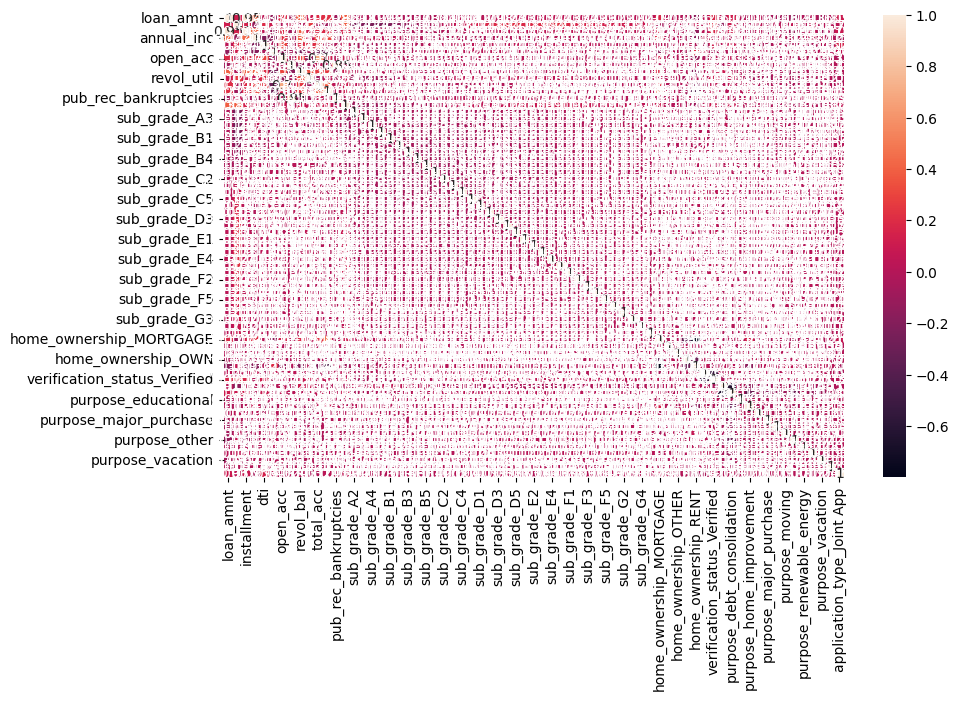

In [ ]:
# @title
pearson_corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr, annot=True)

With this heatmap, we can tell which features are correlated and should be removed. We would perform the below techniques to do so.

# Modeling

## Neural network model

Since our data is huge with more than 1,800,000 rows and 70 features (columns), a traditional `LogisticRegression` may not be able to iterate through all. Thus, we will first build a simple Neural Network model to make predictions, and print out the accuracy score.

In [89]:
simple_nn_model = Sequential([
    tf.keras.Input(shape=X_train.shape[1]),
    Dense(units=25, activation='relu', name='layer_1'),
    Dense(units=10, activation='relu', name='layer_2'),
    Dense(units=1, activation='sigmoid', name='layer_3')              # sigmoid activation for binary classification
])

simple_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 25)                1750      
                                                                 
 layer_2 (Dense)             (None, 10)                260       
                                                                 
 layer_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [90]:
[layer1, layer2, layer3] = simple_nn_model.layers

In [91]:
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()

print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (69, 25), b1 shape = (25,)
W2 shape = (25, 10), b2 shape = (10,)
W3 shape = (10, 1), b3 shape = (1,)


We observe that the shape of `W1` and `b1` is the input shape of our data, containing 69 columns for each neuron unit.

In [100]:
simple_nn_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = [AUC(name='AUC')]
)

history = simple_nn_model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34395/34395 [==============================] - 107s 3ms/step - loss: 0.4523 - AUC: 0.7013
Epoch 2/5
34395/34395 [==============================] - 100s 3ms/step - loss: 0.4523 - AUC: 0.7013
Epoch 3/5
34395/34395 [==============================] - 83s 2ms/step - loss: 0.4524 - AUC: 0.7011
Epoch 4/5
34395/34395 [==============================] - 84s 2ms/step - loss: 0.4523 - AUC: 0.7013
Epoch 5/5
34395/34395 [==============================] - 83s 2ms/step - loss: 0.4523 - AUC: 0.7012


In [101]:
def plot_loss(hist):
  '''
    Plot the loss of the model over time
  '''
  plt.figure(figsize=(20, 12))

  plt.subplot(2, 2, 1)
  plt.plot(hist.history['loss'], label='Loss')
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title("Loss during training")
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(hist.history['AUC'], label='AUC')
  plt.ylabel("AUC")
  plt.xlabel("Epoch")
  plt.title("AUC score")
  plt.legend()

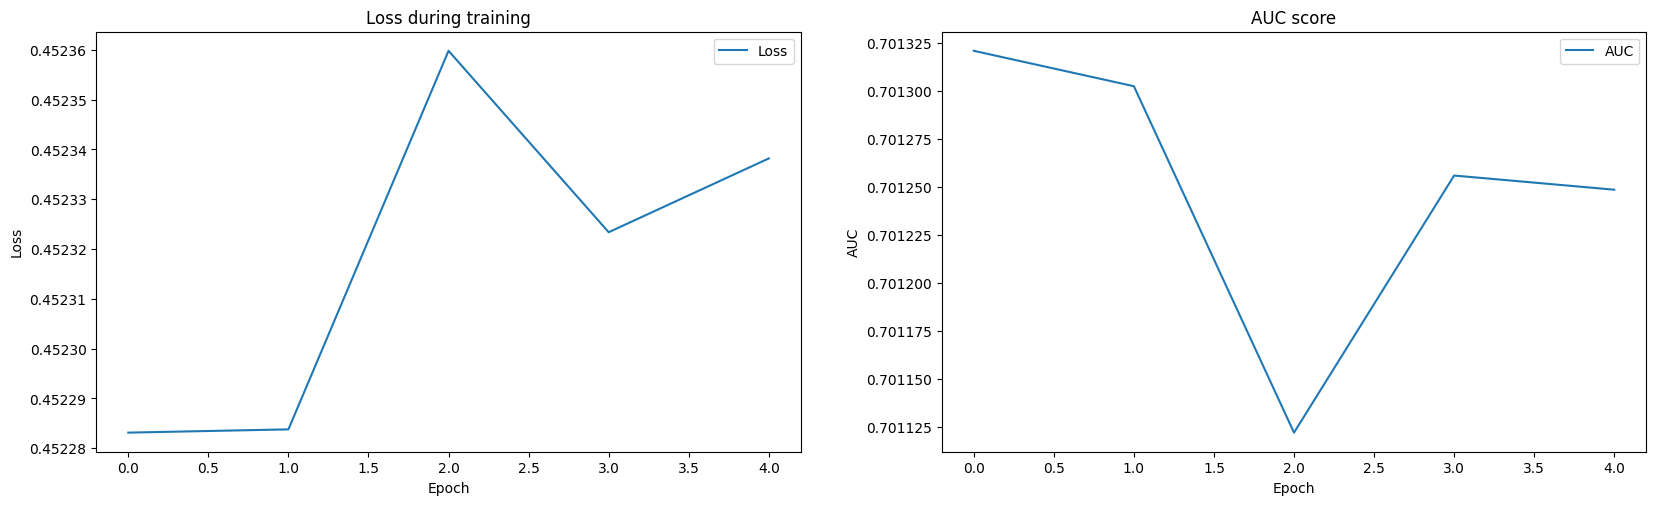

In [102]:
plot_loss(history)

We want to know the accuracy of our model.

In [110]:
def evaluate_model(true, pred, train=True):
  '''
    Prints a report recording the accuracy, AUC score,
    and F1 score of the training model
  '''
  report = pd.DataFrame(classification_report(true, pred, output_dict=True))
  accuracy = accuracy_score(true, pred) * 100
  cf_m = confusion_matrix(true, pred)
  print(f"Accuracy score: {accuracy:.2f}%")
  print(f"\nClassification Report:\n {report}")
  print(f"\nConfusion Matrix:\n {cf_m}")

In [104]:
y_train_pred = simple_nn_model.predict(X_train)             # make prediction for the training set

34395/34395 [==============================] - 82s 2ms/step


In [111]:
evaluate_model(y_train, y_train_pred.round(), train=True)           # record accuracy, AUC, F1 score of the training set

Accuracy score: 80.66%

Classification Report:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision      0.53      0.81      0.81       0.67          0.76
recall         0.06      0.99      0.81       0.52          0.81
f1-score       0.10      0.89      0.81       0.50          0.74
support   214310.00 886316.00      0.81 1100626.00    1100626.00

Confusion Matrix:
 [[ 12398 201912]
 [ 10898 875418]]


So the first simple neural network model returns an okay accuracy. In the confusion matrix, there are 875418 borrowers that we correctly predicted as Fully Paid. This is unsuprising as Fully Paid borrowers account for a majority of our data.

We want to see how well this model generalizes unseen data by passing in the cross-validation set.

In [113]:
y_cv_pred = simple_nn_model.predict(X_cv)

11465/11465 [==============================] - 46s 4ms/step


In [114]:
evaluate_model(y_cv, y_cv_pred.round(), train=True)                 # record accuracy, AUC, F1 score of the cv set

Accuracy score: 80.71%

Classification Report:
                0.0       1.0  accuracy  macro avg  weighted avg
precision     0.54      0.81      0.81       0.68          0.76
recall        0.06      0.99      0.81       0.52          0.81
f1-score      0.10      0.89      0.81       0.50          0.74
support   71375.00 295501.00      0.81  366876.00     366876.00

Confusion Matrix:
 [[  4128  67247]
 [  3518 291983]]


In [115]:
df_cv['loan_status'].value_counts()

1    295501
0     71375
Name: loan_status, dtype: int64

The accuracy in the cv set is fairly okay, but we want to improve its performance a bit.